# About this dataset
Resale transacted prices of flats from different types and locations in Singapore

# Additional Libraries that do not come pre-installed with Anaconda

In [1]:
# !pip install xgboost
# !pip install catboost
# !pip install lightgbm

# Import necessary libraries

In [2]:
%matplotlib inline
# all the basic libraries that we need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style= 'darkgrid')

# pre-processing method
from sklearn.model_selection import train_test_split

# the regression models 
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# methods and classes for evaluation
from sklearn import metrics
from math import sqrt
from sklearn.model_selection import cross_validate
import time

# Import data

In [3]:
df = pd.read_csv('resale-flat-prices-singapore.csv')  # import the csv file
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


# Get to know the data 
### ( shape, dtypes, missing/garbage values, outliers, descriptive statistics, distributions, univariate and bivariate analysis)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50432 entries, 0 to 50431
Data columns (total 11 columns):
month                  50432 non-null object
town                   50432 non-null object
flat_type              50432 non-null object
block                  50432 non-null object
street_name            50432 non-null object
storey_range           50432 non-null object
floor_area_sqm         50432 non-null float64
flat_model             50432 non-null object
lease_commence_date    50432 non-null int64
remaining_lease        50432 non-null object
resale_price           50432 non-null float64
dtypes: float64(2), int64(1), object(8)
memory usage: 4.2+ MB


In [5]:
df.isna().sum()

month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
remaining_lease        0
resale_price           0
dtype: int64

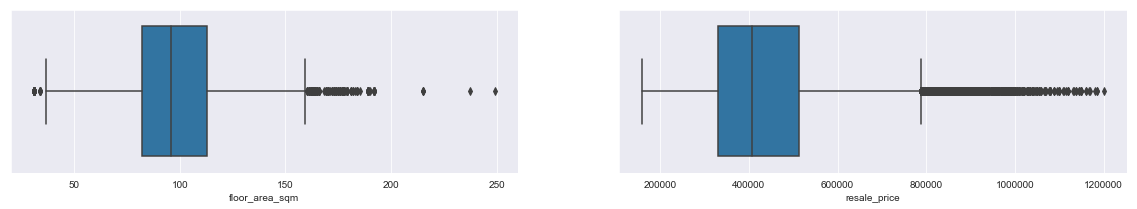

In [6]:
numeric_col = df.columns[pd.Series(df.columns).apply(lambda x : df[x].dtype == 'float64')]  # Non object columns

plt.figure(figsize = (20,3))

j = 1
for i in numeric_col:
    plt.subplot(1,2,j)
    sns.boxplot(df[i])
    j += 1

#### Both the variables seem to be right skewed. And, looking at the outliers in the resale price, there are a lot of mansions among the commons

In [7]:
from datetime import datetime
df.month = df.month.apply(lambda x: datetime.strptime(x, "%Y-%m"))    # Converting dtype of month column from object to datetime

In [8]:
remaining_years = df.remaining_lease.apply(lambda x: int(x[0:2])) #pull out numbers from individual strings of "remaining_lease"
lease_duration = (df.month.apply(lambda x: x.year) - df.lease_commence_date) + remaining_years
lease_duration.value_counts()
# All the leases seem to be 100year leases. So we need only one of the three columns["remaining_lease",
#                                                                                   "Lease_commence_date", "month"]

99     28579
98     21794
100       59
dtype: int64

In [9]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
encoded_df = pd.DataFrame()
object_col = df.columns[pd.Series(df.columns).apply(lambda x : df[x].dtype == 'O')] 
for i in df.columns:
    if i in object_col:
        encoded_df[i] = le.fit_transform(df[i])
    else:
        encoded_df[i] = df[i]

#Encode the categorical variables

In [10]:
encoded_df.dtypes

month                  datetime64[ns]
town                            int32
flat_type                       int32
block                           int32
street_name                     int32
storey_range                    int32
floor_area_sqm                float64
flat_model                      int32
lease_commence_date             int64
remaining_lease                 int32
resale_price                  float64
dtype: object

In [11]:
# convert data type of categorical columns as "category" type
for i in df.columns:
    if df[i].dtype == 'O':
        encoded_df[i] = encoded_df[i].astype('category')
    else:
        pass

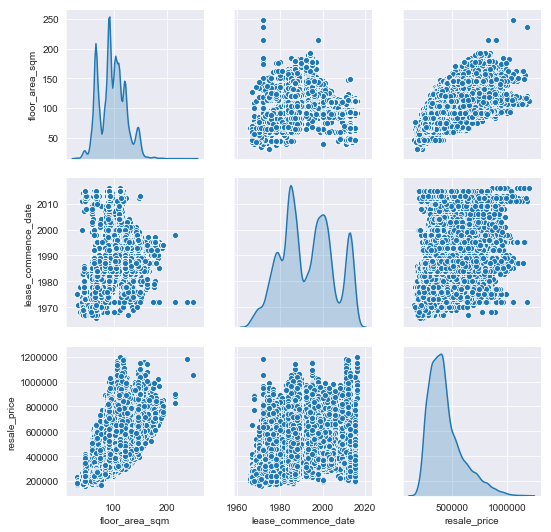

In [12]:
sns.pairplot(df, diag_kind= 'kde')
plt.show()

* There seems to be a slight correlation of "floor_area_sqm" and "resale_price" 
* Resale_price is right skewed as we inferred from the boxplot earlier

# Pick out X(predictor(s)) and y(response)

In [13]:
encoded_df.columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price'],
      dtype='object')

In [14]:
# drop "month" and "lease" along with the target column, because all are 100 year leases.
X = encoded_df.drop(columns= ['month', 'remaining_lease', 'resale_price'])
y = encoded_df.resale_price

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 1)

# Train and evaluate models

In [19]:
def fit_n_print(model, X_train, X_test, y_train, y_test):  # take the model, train data and test data as input
    
    start = time.time()  # note the start time 

    model.fit(X_train, y_train)   # fit the model using the train data

    pred = model.predict(X_test)     # model predictions on the test data

    r2 = metrics.r2_score(y_test, pred)  # calculate the r squared value on the test data
    
    rmse = sqrt(metrics.mean_squared_error(y_test, pred))   # Root mean squared error
    
    rmsle = sqrt(metrics.mean_squared_log_error(y_test, pred))  # Root mean squared log error (since the numbers are huge)
    
    scorer = {'r2' : metrics.make_scorer(metrics.r2_score),
              'mse' : metrics.make_scorer(metrics.mean_squared_error),
              'msle' : metrics.make_scorer(metrics.mean_squared_log_error),
               }    # make scorers to be used in cross validation
    
    cv = cross_validate(model, X_train, y_train, cv=10, scoring = scorer)   # perform cross validation accross 3 metrics
    
    r2_cv = cv['test_r2'].mean()                                     # mean r squared value
    rmse_cv = np.mean([sqrt(mse) for mse in cv['test_mse']]) # mean RMSE value(take root of individual mse value and then mean)
    rmsle_cv = np.mean([sqrt(msle) for msle in cv['test_msle']]) # mean RMSLE
    
    end = time.time()  #note the end time
    
    
    duration = end - start  # calculate the total duration
    
    
    return r2, rmse, rmsle, r2_cv, rmse_cv, rmsle_cv, duration, pred  # return all the metrics along with predictions

In [20]:
lr = LinearRegression()        
dt = DecisionTreeRegressor(random_state=1)   
br = BaggingRegressor(random_state=1)
rf = RandomForestRegressor(random_state=1, n_estimators=100)  # specifying n_estimators to avoid "future warnings"
gb = GradientBoostingRegressor(random_state=1, n_estimators=100)


result = {}   # Create an empty dictionary to later use to store metrics of each of the models

# putting all 5 models in a for loop and appending the results of each of the models to the 'result' dictionary
for model, name  in zip([lr, dt, br, rf, gb], ['Linear Regression', 'Decision Tree',
                                                    'Bagging Ensemble', 'Random Forest', 
                                               'Gradient Boost Ensemble']):
    result[name] = fit_n_print(model,X_train, X_test,y_train, y_test)  
    # store all the metrics in the result dict, with name as key
   
    

In [21]:
result1 = pd.DataFrame(np.array(list(result.values()))[:,:-1],    # make a dataframe out of the metrics from result dictionary 
                       columns= ['R Squared', 'MSE', 'MSLE', 'R2 CV', 'RMSE CV', 'RMSLE CV', 'Elapsed'],
                      index= result.keys())   # use the model names as index

result1.index.name = 'Model'   # name the index of the result1 dataframe as 'Model'

result1 

,R Squared,MSE,MSLE,CV_R2,CV_RMSE,CV_RMSLE,Elapsed
Model,,,,,,,
Linear Regression,0.572798,101139,0.209603,0.573113,100453,0.207289,0.657243
Decision Tree,0.937031,38829.9,0.0836841,0.936076,38863.9,0.0842486,3.53459
Bagging Ensemble,0.958124,31665.7,0.069601,0.955812,32312.3,0.0703856,21.4676
Random Forest,0.960693,30678.7,0.0677324,0.959832,30812.7,0.0677471,194.185
Gradient Boost Ensemble,0.832664,63299.3,0.127729,0.839366,61624.4,0.124478,22.6769


- **Random forest out-performed all the other models**
- However, we have few attributes which have high cardinality which can potential noisy attributes. So let's remove them
- And about the other attributes, let's one-hot encode them

In [22]:
cat_col = X.columns[pd.Series(X.columns).apply(lambda x : X[x].dtype.name == 'category')]   

# check the cardinality of the columns
for i in cat_col:
    print(i, "=>" ,len(X[i].value_counts()))  # print number of categories in each of the categorical columns
    

town => 26
flat_type => 7
block => 2299
street_name => 533
storey_range => 17
flat_model => 20


In [23]:
one_hot_X = X.drop(columns= ['block', 'street_name']) # Because cardinality is high
one_hot_X = pd.get_dummies(one_hot_X, drop_first=True)
one_hot_X.shape

X_train, X_test, y_train, y_test = train_test_split(one_hot_X,y, random_state = 1) 

In [24]:
lr = LinearRegression()        
dt = DecisionTreeRegressor(random_state=1)   
br = BaggingRegressor(random_state=1)
rf = RandomForestRegressor(random_state=1, n_estimators=100)
gb = GradientBoostingRegressor(random_state=1, n_estimators=100)
xgb = XGBRegressor()
cgb = CatBoostRegressor()
lgb = LGBMRegressor()


result = {}   # Create an empty dictionary to later use to store metrics of each of the models

for model, name  in zip([lr, dt, br, rf,
                         gb, xgb, cgb, lgb], ['Linear Regression', 'Decision Tree','Bagging Ensemble', 'Random Forest',
                                              'Gradient Boost Ensemble', 'Xgboost', 'Catboost','LightGB']):
    result[name] = fit_n_print(model,X_train, X_test,y_train, y_test)  
    

C:\Users\PRITHVIRAJ\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:22:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\PRITHVIRAJ\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:22:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\PRITHVIRAJ\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:23:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\PRITHVIRAJ\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:23:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\PRITHVIRAJ\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:23:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\PRITHVIRAJ\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:23:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\PRITHVIRAJ\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:24:00] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\PRITHVIRAJ\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:24:14] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\PRITHVIRAJ\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:24:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\PRITHVIRAJ\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:24:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\PRITHVIRAJ\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:24:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0:	learn: 151158.2837891	total: 58.3ms	remaining: 58.2s
1:	learn: 148558.9327624	total: 68.4ms	remaining: 34.1s
2:	learn: 146103.6753417	total: 78.5ms	remaining: 26.1s
3:	learn: 143731.9800619	total: 87.9ms	remaining: 21.9s
4:	learn: 141382.3776167	total: 97.6ms	remaining: 19.4s
5:	learn: 139128.4078987	total: 108ms	remaining: 17.8s
6:	learn: 136950.7507147	total: 118ms	remaining: 16.7s
7:	learn: 134839.6440725	total: 129ms	remaining: 16s
8:	learn: 132792.2261628	total: 139ms	remaining: 15.3s
9:	learn: 130892.4661696	total: 150ms	remaining: 14.8s
10:	learn: 129158.5287132	total: 160ms	remaining: 14.4s
11:	learn: 127384.3857406	total: 171ms	remaining: 14.1s
12:	learn: 125634.1338167	total: 187ms	remaining: 14.2s
13:	learn: 124112.6937278	total: 199ms	remaining: 14s
14:	learn: 122440.3846547	total: 212ms	remaining: 13.9s
15:	l

159:	learn: 62912.9453526	total: 1.83s	remaining: 9.62s
160:	learn: 62823.8435816	total: 1.84s	remaining: 9.61s
161:	learn: 62700.3643260	total: 1.86s	remaining: 9.61s
162:	learn: 62562.7328197	total: 1.87s	remaining: 9.59s
163:	learn: 62456.6073675	total: 1.88s	remaining: 9.58s
164:	learn: 62354.8987040	total: 1.89s	remaining: 9.57s
165:	learn: 62286.0057994	total: 1.9s	remaining: 9.55s
166:	learn: 62175.2296028	total: 1.91s	remaining: 9.53s
167:	learn: 62080.4148766	total: 1.92s	remaining: 9.51s
168:	learn: 62000.4987624	total: 1.93s	remaining: 9.49s
169:	learn: 61927.0647706	total: 1.94s	remaining: 9.48s
170:	learn: 61839.3252579	total: 1.95s	remaining: 9.46s
171:	learn: 61716.1113100	total: 1.96s	remaining: 9.45s
172:	learn: 61641.2663698	total: 1.97s	remaining: 9.43s
173:	learn: 61560.8388823	total: 1.98s	remaining: 9.41s
174:	learn: 61431.6680964	total: 1.99s	remaining: 9.39s
175:	learn: 61359.9246670	total: 2s	remaining: 9.37s
176:	learn: 61281.4797407	total: 2.01s	remaining: 9.

311:	learn: 53224.8395471	total: 3.44s	remaining: 7.58s
312:	learn: 53192.6077228	total: 3.45s	remaining: 7.58s
313:	learn: 53161.7537167	total: 3.46s	remaining: 7.56s
314:	learn: 53113.5135329	total: 3.47s	remaining: 7.55s
315:	learn: 53070.7107503	total: 3.48s	remaining: 7.54s
316:	learn: 53025.2435389	total: 3.49s	remaining: 7.52s
317:	learn: 52995.2253278	total: 3.5s	remaining: 7.51s
318:	learn: 52956.7906726	total: 3.51s	remaining: 7.5s
319:	learn: 52922.2167664	total: 3.52s	remaining: 7.48s
320:	learn: 52879.1776739	total: 3.53s	remaining: 7.47s
321:	learn: 52852.3413881	total: 3.54s	remaining: 7.45s
322:	learn: 52817.0419681	total: 3.55s	remaining: 7.44s
323:	learn: 52778.0457602	total: 3.56s	remaining: 7.43s
324:	learn: 52743.0573897	total: 3.57s	remaining: 7.41s
325:	learn: 52680.8449155	total: 3.58s	remaining: 7.4s
326:	learn: 52646.7793241	total: 3.59s	remaining: 7.39s
327:	learn: 52612.5978596	total: 3.6s	remaining: 7.38s
328:	learn: 52589.7311166	total: 3.62s	remaining: 7.

470:	learn: 48253.1109769	total: 5.12s	remaining: 5.75s
471:	learn: 48229.5825928	total: 5.14s	remaining: 5.75s
472:	learn: 48202.8030255	total: 5.15s	remaining: 5.74s
473:	learn: 48174.7887312	total: 5.16s	remaining: 5.73s
474:	learn: 48151.4587391	total: 5.17s	remaining: 5.71s
475:	learn: 48124.0997452	total: 5.18s	remaining: 5.7s
476:	learn: 48105.5208122	total: 5.19s	remaining: 5.69s
477:	learn: 48086.1623218	total: 5.2s	remaining: 5.68s
478:	learn: 48070.4491513	total: 5.21s	remaining: 5.67s
479:	learn: 48048.8247897	total: 5.22s	remaining: 5.66s
480:	learn: 48017.0549545	total: 5.23s	remaining: 5.64s
481:	learn: 47990.6385173	total: 5.24s	remaining: 5.63s
482:	learn: 47974.0717337	total: 5.25s	remaining: 5.62s
483:	learn: 47947.1737458	total: 5.26s	remaining: 5.61s
484:	learn: 47914.4905357	total: 5.27s	remaining: 5.59s
485:	learn: 47896.8186555	total: 5.28s	remaining: 5.58s
486:	learn: 47875.9936499	total: 5.29s	remaining: 5.57s
487:	learn: 47853.6650446	total: 5.3s	remaining: 5

622:	learn: 45423.5478894	total: 6.71s	remaining: 4.06s
623:	learn: 45404.4140100	total: 6.72s	remaining: 4.05s
624:	learn: 45389.3658319	total: 6.74s	remaining: 4.04s
625:	learn: 45375.7312923	total: 6.75s	remaining: 4.03s
626:	learn: 45365.6730057	total: 6.76s	remaining: 4.02s
627:	learn: 45352.3874072	total: 6.77s	remaining: 4.01s
628:	learn: 45337.2826338	total: 6.78s	remaining: 4s
629:	learn: 45325.9077013	total: 6.79s	remaining: 3.98s
630:	learn: 45313.9623265	total: 6.79s	remaining: 3.97s
631:	learn: 45308.6170610	total: 6.8s	remaining: 3.96s
632:	learn: 45290.1824210	total: 6.81s	remaining: 3.95s
633:	learn: 45282.9554386	total: 6.82s	remaining: 3.94s
634:	learn: 45258.4572215	total: 6.83s	remaining: 3.93s
635:	learn: 45245.8498506	total: 6.84s	remaining: 3.92s
636:	learn: 45231.5765579	total: 6.85s	remaining: 3.91s
637:	learn: 45213.7071320	total: 6.86s	remaining: 3.89s
638:	learn: 45208.4706142	total: 6.87s	remaining: 3.88s
639:	learn: 45194.1072064	total: 6.88s	remaining: 3.

774:	learn: 43525.3735615	total: 8.29s	remaining: 2.41s
775:	learn: 43508.3548895	total: 8.3s	remaining: 2.4s
776:	learn: 43497.3920776	total: 8.31s	remaining: 2.38s
777:	learn: 43483.5503332	total: 8.32s	remaining: 2.37s
778:	learn: 43474.5055590	total: 8.33s	remaining: 2.36s
779:	learn: 43464.1578540	total: 8.34s	remaining: 2.35s
780:	learn: 43455.8696640	total: 8.35s	remaining: 2.34s
781:	learn: 43445.8935401	total: 8.36s	remaining: 2.33s
782:	learn: 43437.2444796	total: 8.37s	remaining: 2.32s
783:	learn: 43428.0675506	total: 8.38s	remaining: 2.31s
784:	learn: 43424.8162530	total: 8.39s	remaining: 2.3s
785:	learn: 43414.1565321	total: 8.4s	remaining: 2.29s
786:	learn: 43403.5081024	total: 8.41s	remaining: 2.27s
787:	learn: 43396.9123596	total: 8.42s	remaining: 2.26s
788:	learn: 43389.0956091	total: 8.43s	remaining: 2.25s
789:	learn: 43380.4599230	total: 8.44s	remaining: 2.24s
790:	learn: 43366.5645070	total: 8.45s	remaining: 2.23s
791:	learn: 43355.6647207	total: 8.46s	remaining: 2.

924:	learn: 42123.7519097	total: 9.87s	remaining: 800ms
925:	learn: 42115.3886235	total: 9.88s	remaining: 790ms
926:	learn: 42111.5835371	total: 9.89s	remaining: 779ms
927:	learn: 42099.7072824	total: 9.9s	remaining: 768ms
928:	learn: 42085.3411652	total: 9.91s	remaining: 758ms
929:	learn: 42075.4265214	total: 9.92s	remaining: 747ms
930:	learn: 42065.2192026	total: 9.93s	remaining: 736ms
931:	learn: 42056.1710783	total: 9.94s	remaining: 725ms
932:	learn: 42047.8985561	total: 9.95s	remaining: 715ms
933:	learn: 42037.2923217	total: 9.96s	remaining: 704ms
934:	learn: 42029.8767623	total: 9.97s	remaining: 693ms
935:	learn: 42022.2919570	total: 9.98s	remaining: 682ms
936:	learn: 42015.9425374	total: 9.99s	remaining: 672ms
937:	learn: 42004.9413282	total: 10s	remaining: 661ms
938:	learn: 41991.3540545	total: 10s	remaining: 650ms
939:	learn: 41983.9806787	total: 10s	remaining: 640ms
940:	learn: 41971.7623439	total: 10s	remaining: 629ms
941:	learn: 41964.5228733	total: 10s	remaining: 618ms
942

85:	learn: 76202.1663802	total: 912ms	remaining: 9.69s
86:	learn: 75951.4179241	total: 924ms	remaining: 9.69s
87:	learn: 75715.2801582	total: 936ms	remaining: 9.7s
88:	learn: 75481.3542890	total: 945ms	remaining: 9.67s
89:	learn: 75260.1304490	total: 954ms	remaining: 9.65s
90:	learn: 75061.3027295	total: 964ms	remaining: 9.63s
91:	learn: 74764.6774646	total: 973ms	remaining: 9.6s
92:	learn: 74507.1087642	total: 982ms	remaining: 9.58s
93:	learn: 74288.8221254	total: 992ms	remaining: 9.56s
94:	learn: 74047.3251361	total: 1s	remaining: 9.54s
95:	learn: 73843.8046824	total: 1.01s	remaining: 9.51s
96:	learn: 73634.1792427	total: 1.02s	remaining: 9.48s
97:	learn: 73454.5867397	total: 1.03s	remaining: 9.46s
98:	learn: 73269.6385514	total: 1.04s	remaining: 9.44s
99:	learn: 72968.6330362	total: 1.05s	remaining: 9.41s
100:	learn: 72684.7078440	total: 1.05s	remaining: 9.39s
101:	learn: 72511.0020856	total: 1.06s	remaining: 9.37s
102:	learn: 72244.3854181	total: 1.07s	remaining: 9.35s
103:	learn: 

244:	learn: 56472.4426923	total: 2.5s	remaining: 7.7s
245:	learn: 56425.7005875	total: 2.51s	remaining: 7.7s
246:	learn: 56360.5693038	total: 2.52s	remaining: 7.69s
247:	learn: 56306.6895581	total: 2.53s	remaining: 7.68s
248:	learn: 56270.2551746	total: 2.54s	remaining: 7.67s
249:	learn: 56227.6504377	total: 2.55s	remaining: 7.66s
250:	learn: 56176.3110742	total: 2.56s	remaining: 7.64s
251:	learn: 56109.3631477	total: 2.57s	remaining: 7.63s
252:	learn: 56036.1309158	total: 2.58s	remaining: 7.62s
253:	learn: 55995.8015986	total: 2.59s	remaining: 7.61s
254:	learn: 55928.2553410	total: 2.6s	remaining: 7.59s
255:	learn: 55885.6520820	total: 2.61s	remaining: 7.58s
256:	learn: 55819.1797445	total: 2.62s	remaining: 7.57s
257:	learn: 55764.8088560	total: 2.63s	remaining: 7.55s
258:	learn: 55711.5951023	total: 2.64s	remaining: 7.54s
259:	learn: 55672.8124486	total: 2.65s	remaining: 7.53s
260:	learn: 55621.1271232	total: 2.65s	remaining: 7.52s
261:	learn: 55568.6216917	total: 2.67s	remaining: 7.

403:	learn: 50199.4986534	total: 4.08s	remaining: 6.01s
404:	learn: 50154.6969516	total: 4.09s	remaining: 6.01s
405:	learn: 50122.1564120	total: 4.1s	remaining: 6s
406:	learn: 50106.7678007	total: 4.11s	remaining: 5.99s
407:	learn: 50072.5015412	total: 4.12s	remaining: 5.98s
408:	learn: 50045.7794535	total: 4.14s	remaining: 5.98s
409:	learn: 50013.0282209	total: 4.15s	remaining: 5.97s
410:	learn: 49983.2771452	total: 4.16s	remaining: 5.96s
411:	learn: 49957.6867627	total: 4.17s	remaining: 5.95s
412:	learn: 49931.4319129	total: 4.17s	remaining: 5.93s
413:	learn: 49906.2439897	total: 4.19s	remaining: 5.92s
414:	learn: 49881.3312316	total: 4.2s	remaining: 5.91s
415:	learn: 49860.1634136	total: 4.2s	remaining: 5.9s
416:	learn: 49826.2516281	total: 4.21s	remaining: 5.89s
417:	learn: 49797.6835067	total: 4.22s	remaining: 5.88s
418:	learn: 49776.9331135	total: 4.23s	remaining: 5.87s
419:	learn: 49748.8988389	total: 4.24s	remaining: 5.86s
420:	learn: 49721.4900480	total: 4.25s	remaining: 5.85s

564:	learn: 46482.5046431	total: 5.67s	remaining: 4.36s
565:	learn: 46466.1031969	total: 5.68s	remaining: 4.36s
566:	learn: 46444.9383500	total: 5.69s	remaining: 4.35s
567:	learn: 46428.6587313	total: 5.7s	remaining: 4.34s
568:	learn: 46419.1861252	total: 5.71s	remaining: 4.33s
569:	learn: 46398.5917757	total: 5.72s	remaining: 4.32s
570:	learn: 46384.3428663	total: 5.73s	remaining: 4.31s
571:	learn: 46364.7468532	total: 5.74s	remaining: 4.3s
572:	learn: 46348.4370209	total: 5.76s	remaining: 4.29s
573:	learn: 46328.0860380	total: 5.76s	remaining: 4.28s
574:	learn: 46305.8446735	total: 5.78s	remaining: 4.27s
575:	learn: 46288.9571661	total: 5.79s	remaining: 4.26s
576:	learn: 46275.6215661	total: 5.8s	remaining: 4.25s
577:	learn: 46261.0831561	total: 5.8s	remaining: 4.24s
578:	learn: 46248.6816276	total: 5.81s	remaining: 4.23s
579:	learn: 46234.9524733	total: 5.82s	remaining: 4.22s
580:	learn: 46225.7683683	total: 5.83s	remaining: 4.21s
581:	learn: 46213.7038449	total: 5.84s	remaining: 4.

723:	learn: 44227.6268928	total: 7.24s	remaining: 2.76s
724:	learn: 44219.2106534	total: 7.25s	remaining: 2.75s
725:	learn: 44206.1857806	total: 7.26s	remaining: 2.74s
726:	learn: 44195.9065664	total: 7.28s	remaining: 2.73s
727:	learn: 44187.7784013	total: 7.28s	remaining: 2.72s
728:	learn: 44175.1001814	total: 7.29s	remaining: 2.71s
729:	learn: 44167.2404076	total: 7.3s	remaining: 2.7s
730:	learn: 44162.7523386	total: 7.31s	remaining: 2.69s
731:	learn: 44153.5775839	total: 7.32s	remaining: 2.68s
732:	learn: 44146.2944822	total: 7.33s	remaining: 2.67s
733:	learn: 44132.3484409	total: 7.34s	remaining: 2.66s
734:	learn: 44110.7704924	total: 7.35s	remaining: 2.65s
735:	learn: 44101.1689733	total: 7.36s	remaining: 2.64s
736:	learn: 44097.5206666	total: 7.36s	remaining: 2.63s
737:	learn: 44093.9152450	total: 7.37s	remaining: 2.62s
738:	learn: 44084.3901593	total: 7.38s	remaining: 2.61s
739:	learn: 44074.0475702	total: 7.39s	remaining: 2.6s
740:	learn: 44056.6888843	total: 7.4s	remaining: 2.

886:	learn: 42571.8168995	total: 8.83s	remaining: 1.12s
887:	learn: 42561.5131332	total: 8.84s	remaining: 1.11s
888:	learn: 42552.2851867	total: 8.85s	remaining: 1.1s
889:	learn: 42545.2336011	total: 8.86s	remaining: 1.09s
890:	learn: 42542.2893067	total: 8.87s	remaining: 1.08s
891:	learn: 42534.0114784	total: 8.88s	remaining: 1.07s
892:	learn: 42527.4318984	total: 8.89s	remaining: 1.06s
893:	learn: 42521.2826715	total: 8.9s	remaining: 1.05s
894:	learn: 42511.2957919	total: 8.91s	remaining: 1.04s
895:	learn: 42508.4533534	total: 8.92s	remaining: 1.03s
896:	learn: 42500.2141391	total: 8.93s	remaining: 1.02s
897:	learn: 42491.7816878	total: 8.94s	remaining: 1.01s
898:	learn: 42484.1808209	total: 8.95s	remaining: 1s
899:	learn: 42474.7504532	total: 8.95s	remaining: 995ms
900:	learn: 42466.7839213	total: 8.96s	remaining: 985ms
901:	learn: 42460.9222045	total: 8.97s	remaining: 975ms
902:	learn: 42458.7120380	total: 8.98s	remaining: 965ms
903:	learn: 42447.9081693	total: 8.99s	remaining: 955

38:	learn: 97130.8067294	total: 386ms	remaining: 9.52s
39:	learn: 96413.4089058	total: 405ms	remaining: 9.72s
40:	learn: 95755.7637301	total: 415ms	remaining: 9.7s
41:	learn: 95112.2639017	total: 424ms	remaining: 9.68s
42:	learn: 94507.5160442	total: 434ms	remaining: 9.66s
43:	learn: 93903.7952483	total: 443ms	remaining: 9.63s
44:	learn: 93282.3808281	total: 452ms	remaining: 9.6s
45:	learn: 92676.5870709	total: 461ms	remaining: 9.57s
46:	learn: 92117.7265146	total: 470ms	remaining: 9.53s
47:	learn: 91557.6550008	total: 479ms	remaining: 9.51s
48:	learn: 91048.7203663	total: 489ms	remaining: 9.49s
49:	learn: 90450.1664202	total: 499ms	remaining: 9.48s
50:	learn: 89870.7759328	total: 508ms	remaining: 9.46s
51:	learn: 89364.4343132	total: 517ms	remaining: 9.43s
52:	learn: 88846.2196299	total: 527ms	remaining: 9.41s
53:	learn: 88304.3716064	total: 536ms	remaining: 9.38s
54:	learn: 87849.0398072	total: 545ms	remaining: 9.36s
55:	learn: 87355.7933262	total: 556ms	remaining: 9.38s
56:	learn: 8

197:	learn: 59640.0196167	total: 2s	remaining: 8.08s
198:	learn: 59570.2200166	total: 2.01s	remaining: 8.08s
199:	learn: 59484.3534677	total: 2.02s	remaining: 8.07s
200:	learn: 59365.0920318	total: 2.03s	remaining: 8.06s
201:	learn: 59312.0019326	total: 2.04s	remaining: 8.05s
202:	learn: 59244.2537227	total: 2.05s	remaining: 8.03s
203:	learn: 59173.6481805	total: 2.06s	remaining: 8.02s
204:	learn: 59062.4574908	total: 2.06s	remaining: 8.01s
205:	learn: 59006.4026711	total: 2.07s	remaining: 8s
206:	learn: 58940.5214590	total: 2.08s	remaining: 7.98s
207:	learn: 58849.8563197	total: 2.09s	remaining: 7.97s
208:	learn: 58775.9895710	total: 2.1s	remaining: 7.96s
209:	learn: 58682.1224199	total: 2.11s	remaining: 7.94s
210:	learn: 58623.1282669	total: 2.12s	remaining: 7.93s
211:	learn: 58572.3424473	total: 2.13s	remaining: 7.92s
212:	learn: 58519.4000619	total: 2.14s	remaining: 7.91s
213:	learn: 58431.0302783	total: 2.15s	remaining: 7.89s
214:	learn: 58358.8856718	total: 2.16s	remaining: 7.9s


354:	learn: 51694.1049843	total: 3.56s	remaining: 6.47s
355:	learn: 51658.4364639	total: 3.57s	remaining: 6.46s
356:	learn: 51624.6129007	total: 3.59s	remaining: 6.46s
357:	learn: 51601.2809572	total: 3.6s	remaining: 6.45s
358:	learn: 51558.8262460	total: 3.6s	remaining: 6.44s
359:	learn: 51526.4646912	total: 3.61s	remaining: 6.43s
360:	learn: 51493.0847025	total: 3.62s	remaining: 6.42s
361:	learn: 51458.5603075	total: 3.63s	remaining: 6.4s
362:	learn: 51429.5580774	total: 3.64s	remaining: 6.39s
363:	learn: 51408.7051488	total: 3.65s	remaining: 6.38s
364:	learn: 51390.1298627	total: 3.66s	remaining: 6.37s
365:	learn: 51357.0553088	total: 3.67s	remaining: 6.36s
366:	learn: 51325.5028333	total: 3.68s	remaining: 6.35s
367:	learn: 51278.2323612	total: 3.7s	remaining: 6.35s
368:	learn: 51251.5794243	total: 3.71s	remaining: 6.34s
369:	learn: 51220.1355030	total: 3.71s	remaining: 6.33s
370:	learn: 51177.8470608	total: 3.72s	remaining: 6.31s
371:	learn: 51138.8346710	total: 3.74s	remaining: 6.

512:	learn: 47465.1803282	total: 5.16s	remaining: 4.89s
513:	learn: 47443.6334881	total: 5.17s	remaining: 4.89s
514:	learn: 47426.0008375	total: 5.18s	remaining: 4.88s
515:	learn: 47393.0675954	total: 5.19s	remaining: 4.87s
516:	learn: 47380.9450677	total: 5.2s	remaining: 4.86s
517:	learn: 47345.7995270	total: 5.21s	remaining: 4.85s
518:	learn: 47327.0982037	total: 5.22s	remaining: 4.83s
519:	learn: 47305.5922810	total: 5.23s	remaining: 4.82s
520:	learn: 47283.2383822	total: 5.24s	remaining: 4.81s
521:	learn: 47268.0675757	total: 5.24s	remaining: 4.8s
522:	learn: 47258.1313159	total: 5.25s	remaining: 4.79s
523:	learn: 47238.0544009	total: 5.26s	remaining: 4.78s
524:	learn: 47218.3578887	total: 5.27s	remaining: 4.77s
525:	learn: 47197.2753010	total: 5.28s	remaining: 4.76s
526:	learn: 47173.0781142	total: 5.29s	remaining: 4.75s
527:	learn: 47150.2483092	total: 5.3s	remaining: 4.74s
528:	learn: 47135.9054898	total: 5.31s	remaining: 4.73s
529:	learn: 47119.0273959	total: 5.33s	remaining: 4

674:	learn: 44760.9019124	total: 6.74s	remaining: 3.24s
675:	learn: 44751.1377569	total: 6.75s	remaining: 3.23s
676:	learn: 44740.0468537	total: 6.76s	remaining: 3.23s
677:	learn: 44729.1940567	total: 6.77s	remaining: 3.21s
678:	learn: 44718.1658329	total: 6.78s	remaining: 3.2s
679:	learn: 44703.4937589	total: 6.79s	remaining: 3.19s
680:	learn: 44690.3140284	total: 6.8s	remaining: 3.18s
681:	learn: 44682.2149363	total: 6.8s	remaining: 3.17s
682:	learn: 44668.3863120	total: 6.81s	remaining: 3.16s
683:	learn: 44655.9884696	total: 6.82s	remaining: 3.15s
684:	learn: 44638.8447767	total: 6.83s	remaining: 3.14s
685:	learn: 44623.8483707	total: 6.84s	remaining: 3.13s
686:	learn: 44606.8292873	total: 6.85s	remaining: 3.12s
687:	learn: 44602.4958325	total: 6.86s	remaining: 3.11s
688:	learn: 44597.4444180	total: 6.87s	remaining: 3.1s
689:	learn: 44582.2460976	total: 6.88s	remaining: 3.09s
690:	learn: 44564.9007934	total: 6.89s	remaining: 3.08s
691:	learn: 44553.3838091	total: 6.89s	remaining: 3.

836:	learn: 42916.3474540	total: 8.32s	remaining: 1.62s
837:	learn: 42905.3260112	total: 8.34s	remaining: 1.61s
838:	learn: 42893.7239755	total: 8.35s	remaining: 1.6s
839:	learn: 42882.9108218	total: 8.36s	remaining: 1.59s
840:	learn: 42867.3900616	total: 8.37s	remaining: 1.58s
841:	learn: 42858.0771201	total: 8.38s	remaining: 1.57s
842:	learn: 42847.6306603	total: 8.39s	remaining: 1.56s
843:	learn: 42838.2597363	total: 8.4s	remaining: 1.55s
844:	learn: 42828.3128835	total: 8.4s	remaining: 1.54s
845:	learn: 42820.2925717	total: 8.41s	remaining: 1.53s
846:	learn: 42809.2804100	total: 8.42s	remaining: 1.52s
847:	learn: 42800.9292599	total: 8.43s	remaining: 1.51s
848:	learn: 42792.6902180	total: 8.44s	remaining: 1.5s
849:	learn: 42780.7295337	total: 8.45s	remaining: 1.49s
850:	learn: 42769.8905710	total: 8.46s	remaining: 1.48s
851:	learn: 42761.8625976	total: 8.47s	remaining: 1.47s
852:	learn: 42752.1444336	total: 8.48s	remaining: 1.46s
853:	learn: 42738.4915860	total: 8.49s	remaining: 1.

997:	learn: 41558.2046376	total: 9.91s	remaining: 19.9ms
998:	learn: 41545.4241450	total: 9.93s	remaining: 9.94ms
999:	learn: 41543.3440754	total: 9.94s	remaining: 0us
0:	learn: 150748.8556929	total: 10.2ms	remaining: 10.2s
1:	learn: 148181.2354362	total: 20ms	remaining: 10s
2:	learn: 145666.7489788	total: 29.4ms	remaining: 9.78s
3:	learn: 143258.8875481	total: 38.8ms	remaining: 9.65s
4:	learn: 140944.9283775	total: 47.8ms	remaining: 9.51s
5:	learn: 138720.7475665	total: 56.8ms	remaining: 9.41s
6:	learn: 136554.5876923	total: 66ms	remaining: 9.36s
7:	learn: 134442.8563976	total: 75.2ms	remaining: 9.32s
8:	learn: 132473.5096031	total: 84.2ms	remaining: 9.28s
9:	learn: 130600.0268384	total: 93.3ms	remaining: 9.24s
10:	learn: 128766.3614722	total: 103ms	remaining: 9.22s
11:	learn: 127041.1854125	total: 111ms	remaining: 9.15s
12:	learn: 125349.7596735	total: 120ms	remaining: 9.12s
13:	learn: 123712.6315702	total: 129ms	remaining: 9.11s
14:	learn: 122139.7126282	total: 139ms	remaining: 9.1s

157:	learn: 63536.4747776	total: 1.59s	remaining: 8.49s
158:	learn: 63449.4832428	total: 1.61s	remaining: 8.54s
159:	learn: 63335.4869384	total: 1.62s	remaining: 8.53s
160:	learn: 63177.7021632	total: 1.63s	remaining: 8.52s
161:	learn: 63045.9177732	total: 1.64s	remaining: 8.5s
162:	learn: 62891.7780392	total: 1.65s	remaining: 8.49s
163:	learn: 62793.1737234	total: 1.66s	remaining: 8.47s
164:	learn: 62690.1783329	total: 1.67s	remaining: 8.46s
165:	learn: 62593.8540069	total: 1.68s	remaining: 8.44s
166:	learn: 62503.0155806	total: 1.69s	remaining: 8.43s
167:	learn: 62395.1461740	total: 1.7s	remaining: 8.42s
168:	learn: 62255.2301053	total: 1.71s	remaining: 8.4s
169:	learn: 62172.1932944	total: 1.72s	remaining: 8.39s
170:	learn: 62077.1022253	total: 1.73s	remaining: 8.37s
171:	learn: 61999.5456175	total: 1.74s	remaining: 8.36s
172:	learn: 61882.3516924	total: 1.75s	remaining: 8.35s
173:	learn: 61755.3150170	total: 1.75s	remaining: 8.34s
174:	learn: 61636.3367883	total: 1.77s	remaining: 8

318:	learn: 52852.0238677	total: 3.2s	remaining: 6.84s
319:	learn: 52822.1142134	total: 3.21s	remaining: 6.83s
320:	learn: 52785.8343655	total: 3.22s	remaining: 6.82s
321:	learn: 52751.7585838	total: 3.23s	remaining: 6.81s
322:	learn: 52724.4899384	total: 3.25s	remaining: 6.8s
323:	learn: 52684.6967623	total: 3.25s	remaining: 6.79s
324:	learn: 52634.5393980	total: 3.27s	remaining: 6.78s
325:	learn: 52592.4656997	total: 3.27s	remaining: 6.77s
326:	learn: 52562.4312841	total: 3.28s	remaining: 6.76s
327:	learn: 52529.8375047	total: 3.29s	remaining: 6.75s
328:	learn: 52487.7272189	total: 3.3s	remaining: 6.74s
329:	learn: 52436.8536604	total: 3.31s	remaining: 6.72s
330:	learn: 52404.8618469	total: 3.32s	remaining: 6.71s
331:	learn: 52372.7722396	total: 3.33s	remaining: 6.7s
332:	learn: 52338.3923114	total: 3.34s	remaining: 6.69s
333:	learn: 52281.7778124	total: 3.35s	remaining: 6.68s
334:	learn: 52235.8647946	total: 3.36s	remaining: 6.67s
335:	learn: 52198.8057808	total: 3.37s	remaining: 6.

478:	learn: 48012.1659069	total: 4.78s	remaining: 5.2s
479:	learn: 47988.7132881	total: 4.79s	remaining: 5.2s
480:	learn: 47968.4185907	total: 4.8s	remaining: 5.18s
481:	learn: 47947.5812031	total: 4.82s	remaining: 5.17s
482:	learn: 47924.3077575	total: 4.82s	remaining: 5.16s
483:	learn: 47901.0169769	total: 4.83s	remaining: 5.15s
484:	learn: 47873.1704099	total: 4.84s	remaining: 5.14s
485:	learn: 47850.0302850	total: 4.85s	remaining: 5.13s
486:	learn: 47829.7177808	total: 4.86s	remaining: 5.12s
487:	learn: 47812.8452905	total: 4.87s	remaining: 5.11s
488:	learn: 47795.3450962	total: 4.88s	remaining: 5.1s
489:	learn: 47764.8171939	total: 4.89s	remaining: 5.09s
490:	learn: 47750.3021669	total: 4.9s	remaining: 5.08s
491:	learn: 47727.0877464	total: 4.91s	remaining: 5.07s
492:	learn: 47710.7918493	total: 4.92s	remaining: 5.06s
493:	learn: 47695.9652027	total: 4.92s	remaining: 5.04s
494:	learn: 47677.9422554	total: 4.93s	remaining: 5.03s
495:	learn: 47654.3243334	total: 4.94s	remaining: 5.0

640:	learn: 45102.6921753	total: 6.37s	remaining: 3.57s
641:	learn: 45093.8185861	total: 6.38s	remaining: 3.56s
642:	learn: 45073.9483712	total: 6.39s	remaining: 3.55s
643:	learn: 45050.0275455	total: 6.4s	remaining: 3.54s
644:	learn: 45027.1202910	total: 6.41s	remaining: 3.53s
645:	learn: 45013.1445015	total: 6.42s	remaining: 3.52s
646:	learn: 45000.4546804	total: 6.43s	remaining: 3.51s
647:	learn: 44988.6359518	total: 6.44s	remaining: 3.5s
648:	learn: 44974.8072342	total: 6.45s	remaining: 3.49s
649:	learn: 44970.0994152	total: 6.46s	remaining: 3.48s
650:	learn: 44955.6645791	total: 6.47s	remaining: 3.47s
651:	learn: 44945.8247523	total: 6.48s	remaining: 3.46s
652:	learn: 44927.1340159	total: 6.49s	remaining: 3.45s
653:	learn: 44911.0633956	total: 6.5s	remaining: 3.44s
654:	learn: 44894.8715101	total: 6.51s	remaining: 3.43s
655:	learn: 44879.8724574	total: 6.52s	remaining: 3.42s
656:	learn: 44865.8251653	total: 6.54s	remaining: 3.41s
657:	learn: 44846.3470876	total: 6.55s	remaining: 3

803:	learn: 43152.7199785	total: 7.95s	remaining: 1.94s
804:	learn: 43141.2594494	total: 7.96s	remaining: 1.93s
805:	learn: 43124.9513989	total: 7.98s	remaining: 1.92s
806:	learn: 43115.8730576	total: 7.99s	remaining: 1.91s
807:	learn: 43101.2195739	total: 8s	remaining: 1.9s
808:	learn: 43088.2809819	total: 8s	remaining: 1.89s
809:	learn: 43085.5601393	total: 8.01s	remaining: 1.88s
810:	learn: 43074.6920144	total: 8.02s	remaining: 1.87s
811:	learn: 43065.2185019	total: 8.03s	remaining: 1.86s
812:	learn: 43053.3816567	total: 8.04s	remaining: 1.85s
813:	learn: 43041.5504248	total: 8.05s	remaining: 1.84s
814:	learn: 43025.9900652	total: 8.06s	remaining: 1.83s
815:	learn: 43003.7726362	total: 8.07s	remaining: 1.82s
816:	learn: 42996.3677430	total: 8.08s	remaining: 1.81s
817:	learn: 42988.5605840	total: 8.09s	remaining: 1.8s
818:	learn: 42976.1019344	total: 8.1s	remaining: 1.79s
819:	learn: 42967.1622553	total: 8.1s	remaining: 1.78s
820:	learn: 42959.6147716	total: 8.11s	remaining: 1.77s
82

964:	learn: 41711.0601703	total: 9.54s	remaining: 346ms
965:	learn: 41702.2509923	total: 9.55s	remaining: 336ms
966:	learn: 41698.4520868	total: 9.56s	remaining: 326ms
967:	learn: 41690.8163538	total: 9.57s	remaining: 316ms
968:	learn: 41683.3513734	total: 9.58s	remaining: 307ms
969:	learn: 41680.8292475	total: 9.59s	remaining: 297ms
970:	learn: 41671.6569481	total: 9.6s	remaining: 287ms
971:	learn: 41664.2699206	total: 9.61s	remaining: 277ms
972:	learn: 41651.6108972	total: 9.62s	remaining: 267ms
973:	learn: 41644.6493131	total: 9.63s	remaining: 257ms
974:	learn: 41638.9630444	total: 9.64s	remaining: 247ms
975:	learn: 41628.6723648	total: 9.64s	remaining: 237ms
976:	learn: 41617.8148921	total: 9.65s	remaining: 227ms
977:	learn: 41610.4653924	total: 9.66s	remaining: 217ms
978:	learn: 41604.2539793	total: 9.67s	remaining: 207ms
979:	learn: 41593.5628985	total: 9.68s	remaining: 198ms
980:	learn: 41586.2038740	total: 9.69s	remaining: 188ms
981:	learn: 41579.4644201	total: 9.7s	remaining: 

123:	learn: 68164.8681745	total: 1.25s	remaining: 8.84s
124:	learn: 68027.1401264	total: 1.27s	remaining: 8.89s
125:	learn: 67886.3848665	total: 1.28s	remaining: 8.88s
126:	learn: 67719.1880901	total: 1.29s	remaining: 8.86s
127:	learn: 67585.2410099	total: 1.3s	remaining: 8.85s
128:	learn: 67447.8968989	total: 1.31s	remaining: 8.83s
129:	learn: 67307.6274164	total: 1.32s	remaining: 8.82s
130:	learn: 67168.0405418	total: 1.33s	remaining: 8.8s
131:	learn: 66973.6545516	total: 1.34s	remaining: 8.79s
132:	learn: 66809.6498367	total: 1.34s	remaining: 8.77s
133:	learn: 66644.0066661	total: 1.35s	remaining: 8.75s
134:	learn: 66497.8930358	total: 1.36s	remaining: 8.74s
135:	learn: 66369.7584887	total: 1.37s	remaining: 8.72s
136:	learn: 66225.1587931	total: 1.38s	remaining: 8.71s
137:	learn: 66097.0519454	total: 1.39s	remaining: 8.7s
138:	learn: 65932.2780458	total: 1.4s	remaining: 8.68s
139:	learn: 65759.8440647	total: 1.41s	remaining: 8.67s
140:	learn: 65531.8690688	total: 1.42s	remaining: 8.

283:	learn: 54411.1176358	total: 2.84s	remaining: 7.16s
284:	learn: 54378.7921660	total: 2.85s	remaining: 7.15s
285:	learn: 54317.5690406	total: 2.86s	remaining: 7.14s
286:	learn: 54279.1745777	total: 2.87s	remaining: 7.13s
287:	learn: 54240.7741800	total: 2.88s	remaining: 7.12s
288:	learn: 54194.8592723	total: 2.89s	remaining: 7.11s
289:	learn: 54158.0554580	total: 2.9s	remaining: 7.1s
290:	learn: 54115.4277949	total: 2.91s	remaining: 7.09s
291:	learn: 54071.1774422	total: 2.92s	remaining: 7.08s
292:	learn: 54029.9068037	total: 2.93s	remaining: 7.06s
293:	learn: 53993.8764294	total: 2.94s	remaining: 7.05s
294:	learn: 53933.6728614	total: 2.95s	remaining: 7.04s
295:	learn: 53887.3519603	total: 2.96s	remaining: 7.03s
296:	learn: 53850.3128317	total: 2.96s	remaining: 7.02s
297:	learn: 53789.7463979	total: 2.97s	remaining: 7.01s
298:	learn: 53743.3399482	total: 2.98s	remaining: 6.99s
299:	learn: 53702.9066925	total: 2.99s	remaining: 6.98s
300:	learn: 53657.5292262	total: 3s	remaining: 6.9

445:	learn: 48938.2114258	total: 4.42s	remaining: 5.49s
446:	learn: 48917.1036725	total: 4.44s	remaining: 5.49s
447:	learn: 48899.1657179	total: 4.45s	remaining: 5.48s
448:	learn: 48875.9571303	total: 4.46s	remaining: 5.47s
449:	learn: 48855.9083417	total: 4.47s	remaining: 5.46s
450:	learn: 48832.5343297	total: 4.47s	remaining: 5.45s
451:	learn: 48810.3437258	total: 4.48s	remaining: 5.44s
452:	learn: 48786.3182928	total: 4.49s	remaining: 5.43s
453:	learn: 48757.9799753	total: 4.5s	remaining: 5.42s
454:	learn: 48738.6590551	total: 4.51s	remaining: 5.41s
455:	learn: 48715.2689245	total: 4.52s	remaining: 5.39s
456:	learn: 48686.8830881	total: 4.53s	remaining: 5.38s
457:	learn: 48660.9641657	total: 4.54s	remaining: 5.37s
458:	learn: 48632.6029430	total: 4.55s	remaining: 5.36s
459:	learn: 48608.2522252	total: 4.56s	remaining: 5.35s
460:	learn: 48579.4081964	total: 4.57s	remaining: 5.34s
461:	learn: 48560.3111081	total: 4.58s	remaining: 5.33s
462:	learn: 48542.2659643	total: 4.59s	remaining:

594:	learn: 45950.3573222	total: 6.02s	remaining: 4.1s
595:	learn: 45944.4197531	total: 6.03s	remaining: 4.09s
596:	learn: 45928.2395621	total: 6.05s	remaining: 4.08s
597:	learn: 45916.4369275	total: 6.06s	remaining: 4.07s
598:	learn: 45902.7263319	total: 6.07s	remaining: 4.06s
599:	learn: 45880.4317938	total: 6.08s	remaining: 4.05s
600:	learn: 45860.1889337	total: 6.09s	remaining: 4.04s
601:	learn: 45848.6398978	total: 6.1s	remaining: 4.03s
602:	learn: 45833.6479208	total: 6.11s	remaining: 4.02s
603:	learn: 45816.7108717	total: 6.12s	remaining: 4.01s
604:	learn: 45796.3492004	total: 6.12s	remaining: 4s
605:	learn: 45773.2823875	total: 6.13s	remaining: 3.99s
606:	learn: 45758.5299300	total: 6.14s	remaining: 3.98s
607:	learn: 45746.6199822	total: 6.15s	remaining: 3.97s
608:	learn: 45735.7153576	total: 6.16s	remaining: 3.96s
609:	learn: 45729.8795200	total: 6.17s	remaining: 3.94s
610:	learn: 45706.3939527	total: 6.18s	remaining: 3.93s
611:	learn: 45687.1210502	total: 6.19s	remaining: 3.9

749:	learn: 43911.2947889	total: 8.02s	remaining: 2.67s
750:	learn: 43898.7192176	total: 8.03s	remaining: 2.66s
751:	learn: 43884.2871293	total: 8.06s	remaining: 2.66s
752:	learn: 43878.9575839	total: 8.09s	remaining: 2.65s
753:	learn: 43867.9294854	total: 8.11s	remaining: 2.64s
754:	learn: 43857.1957562	total: 8.12s	remaining: 2.63s
755:	learn: 43841.8054026	total: 8.13s	remaining: 2.62s
756:	learn: 43837.7230759	total: 8.14s	remaining: 2.61s
757:	learn: 43827.6658532	total: 8.16s	remaining: 2.6s
758:	learn: 43808.6896048	total: 8.17s	remaining: 2.59s
759:	learn: 43794.0943446	total: 8.18s	remaining: 2.58s
760:	learn: 43782.5792783	total: 8.19s	remaining: 2.57s
761:	learn: 43772.5110908	total: 8.2s	remaining: 2.56s
762:	learn: 43765.7815336	total: 8.21s	remaining: 2.55s
763:	learn: 43759.6632698	total: 8.22s	remaining: 2.54s
764:	learn: 43745.5933504	total: 8.23s	remaining: 2.53s
765:	learn: 43735.4695422	total: 8.24s	remaining: 2.52s
766:	learn: 43723.2390386	total: 8.25s	remaining: 

908:	learn: 42374.2502684	total: 9.8s	remaining: 981ms
909:	learn: 42367.8911006	total: 9.81s	remaining: 970ms
910:	learn: 42359.6343636	total: 9.82s	remaining: 959ms
911:	learn: 42353.9366638	total: 9.83s	remaining: 948ms
912:	learn: 42348.1025407	total: 9.84s	remaining: 938ms
913:	learn: 42335.7188530	total: 9.85s	remaining: 927ms
914:	learn: 42328.7419444	total: 9.86s	remaining: 916ms
915:	learn: 42320.2481394	total: 9.87s	remaining: 905ms
916:	learn: 42306.5085304	total: 9.88s	remaining: 894ms
917:	learn: 42297.1474211	total: 9.89s	remaining: 884ms
918:	learn: 42288.2726213	total: 9.9s	remaining: 873ms
919:	learn: 42281.9462387	total: 9.92s	remaining: 862ms
920:	learn: 42272.3105627	total: 9.93s	remaining: 852ms
921:	learn: 42260.4987719	total: 9.94s	remaining: 841ms
922:	learn: 42253.3214119	total: 9.95s	remaining: 830ms
923:	learn: 42243.6428915	total: 9.97s	remaining: 820ms
924:	learn: 42229.7818641	total: 9.98s	remaining: 809ms
925:	learn: 42223.6200379	total: 9.99s	remaining: 

57:	learn: 86346.3266222	total: 722ms	remaining: 11.7s
58:	learn: 85893.3041442	total: 744ms	remaining: 11.9s
59:	learn: 85498.0453768	total: 757ms	remaining: 11.9s
60:	learn: 85099.5052377	total: 766ms	remaining: 11.8s
61:	learn: 84646.1606744	total: 777ms	remaining: 11.8s
62:	learn: 84199.8081536	total: 786ms	remaining: 11.7s
63:	learn: 83747.7707070	total: 797ms	remaining: 11.7s
64:	learn: 83320.7685112	total: 806ms	remaining: 11.6s
65:	learn: 82892.7596559	total: 816ms	remaining: 11.6s
66:	learn: 82525.0409235	total: 828ms	remaining: 11.5s
67:	learn: 82206.5585701	total: 839ms	remaining: 11.5s
68:	learn: 81880.6682804	total: 849ms	remaining: 11.4s
69:	learn: 81534.3848825	total: 858ms	remaining: 11.4s
70:	learn: 81155.5324223	total: 867ms	remaining: 11.3s
71:	learn: 80868.4737586	total: 876ms	remaining: 11.3s
72:	learn: 80534.5809487	total: 885ms	remaining: 11.2s
73:	learn: 80204.8602962	total: 898ms	remaining: 11.2s
74:	learn: 79896.1019809	total: 913ms	remaining: 11.3s
75:	learn:

218:	learn: 58417.9590865	total: 2.49s	remaining: 8.88s
219:	learn: 58358.0617096	total: 2.5s	remaining: 8.88s
220:	learn: 58304.4126472	total: 2.52s	remaining: 8.88s
221:	learn: 58200.7096219	total: 2.53s	remaining: 8.88s
222:	learn: 58144.4401321	total: 2.56s	remaining: 8.9s
223:	learn: 58094.0401073	total: 2.57s	remaining: 8.91s
224:	learn: 58034.3069699	total: 2.6s	remaining: 8.95s
225:	learn: 57982.0812922	total: 2.66s	remaining: 9.1s
226:	learn: 57921.4662098	total: 2.68s	remaining: 9.14s
227:	learn: 57851.5009542	total: 2.7s	remaining: 9.15s
228:	learn: 57785.9682993	total: 2.72s	remaining: 9.17s
229:	learn: 57724.9162527	total: 2.74s	remaining: 9.17s
230:	learn: 57668.2732251	total: 2.75s	remaining: 9.16s
231:	learn: 57577.4495221	total: 2.76s	remaining: 9.14s
232:	learn: 57530.4619012	total: 2.78s	remaining: 9.14s
233:	learn: 57485.5123011	total: 2.79s	remaining: 9.13s
234:	learn: 57432.8161047	total: 2.8s	remaining: 9.11s
235:	learn: 57378.0615712	total: 2.81s	remaining: 9.1s

371:	learn: 51459.7521341	total: 4.43s	remaining: 7.48s
372:	learn: 51419.8504656	total: 4.45s	remaining: 7.47s
373:	learn: 51388.3844317	total: 4.46s	remaining: 7.46s
374:	learn: 51329.6885682	total: 4.48s	remaining: 7.47s
375:	learn: 51293.2708869	total: 4.51s	remaining: 7.49s
376:	learn: 51258.8609105	total: 4.53s	remaining: 7.49s
377:	learn: 51236.5939910	total: 4.56s	remaining: 7.5s
378:	learn: 51203.2763219	total: 4.57s	remaining: 7.49s
379:	learn: 51173.6490928	total: 4.59s	remaining: 7.49s
380:	learn: 51147.0522223	total: 4.6s	remaining: 7.48s
381:	learn: 51125.2245988	total: 4.63s	remaining: 7.48s
382:	learn: 51107.4948694	total: 4.64s	remaining: 7.47s
383:	learn: 51067.4790573	total: 4.65s	remaining: 7.46s
384:	learn: 51042.4246521	total: 4.67s	remaining: 7.47s
385:	learn: 51014.7481805	total: 4.7s	remaining: 7.48s
386:	learn: 50992.0987533	total: 4.71s	remaining: 7.47s
387:	learn: 50959.4126511	total: 4.73s	remaining: 7.46s
388:	learn: 50914.2511596	total: 4.74s	remaining: 7

521:	learn: 47357.7308867	total: 6.41s	remaining: 5.87s
522:	learn: 47331.6997901	total: 6.43s	remaining: 5.87s
523:	learn: 47311.0408964	total: 6.44s	remaining: 5.85s
524:	learn: 47288.7678992	total: 6.45s	remaining: 5.84s
525:	learn: 47267.1960910	total: 6.47s	remaining: 5.83s
526:	learn: 47255.5877589	total: 6.48s	remaining: 5.82s
527:	learn: 47244.8916349	total: 6.49s	remaining: 5.8s
528:	learn: 47224.5295402	total: 6.5s	remaining: 5.79s
529:	learn: 47202.8875436	total: 6.52s	remaining: 5.78s
530:	learn: 47177.9518600	total: 6.53s	remaining: 5.76s
531:	learn: 47158.6830521	total: 6.54s	remaining: 5.75s
532:	learn: 47138.6334651	total: 6.55s	remaining: 5.74s
533:	learn: 47116.9940378	total: 6.56s	remaining: 5.73s
534:	learn: 47090.1979277	total: 6.57s	remaining: 5.71s
535:	learn: 47059.4624326	total: 6.58s	remaining: 5.7s
536:	learn: 47034.9276695	total: 6.6s	remaining: 5.69s
537:	learn: 47016.3685058	total: 6.61s	remaining: 5.68s
538:	learn: 47005.0586065	total: 6.62s	remaining: 5.

674:	learn: 44790.5537483	total: 7.99s	remaining: 3.85s
675:	learn: 44780.4705915	total: 8s	remaining: 3.83s
676:	learn: 44765.6771810	total: 8.01s	remaining: 3.82s
677:	learn: 44746.6010424	total: 8.02s	remaining: 3.81s
678:	learn: 44733.3986909	total: 8.03s	remaining: 3.8s
679:	learn: 44714.0671566	total: 8.04s	remaining: 3.79s
680:	learn: 44700.9535974	total: 8.05s	remaining: 3.77s
681:	learn: 44684.5673048	total: 8.06s	remaining: 3.76s
682:	learn: 44677.2189842	total: 8.07s	remaining: 3.75s
683:	learn: 44658.0200084	total: 8.08s	remaining: 3.73s
684:	learn: 44648.4800655	total: 8.09s	remaining: 3.72s
685:	learn: 44637.6074434	total: 8.1s	remaining: 3.71s
686:	learn: 44624.7728617	total: 8.11s	remaining: 3.69s
687:	learn: 44608.8974165	total: 8.12s	remaining: 3.68s
688:	learn: 44603.7687699	total: 8.13s	remaining: 3.67s
689:	learn: 44589.3985256	total: 8.14s	remaining: 3.65s
690:	learn: 44577.1331789	total: 8.14s	remaining: 3.64s
691:	learn: 44560.3380961	total: 8.15s	remaining: 3.6

823:	learn: 43038.1042047	total: 9.59s	remaining: 2.05s
824:	learn: 43024.6608134	total: 9.6s	remaining: 2.04s
825:	learn: 43017.8105615	total: 9.62s	remaining: 2.03s
826:	learn: 43005.7005464	total: 9.63s	remaining: 2.02s
827:	learn: 43002.4905861	total: 9.64s	remaining: 2s
828:	learn: 42993.3429593	total: 9.65s	remaining: 1.99s
829:	learn: 42984.2015559	total: 9.66s	remaining: 1.98s
830:	learn: 42973.9492675	total: 9.67s	remaining: 1.97s
831:	learn: 42966.8364427	total: 9.68s	remaining: 1.96s
832:	learn: 42958.9195207	total: 9.69s	remaining: 1.94s
833:	learn: 42955.6203737	total: 9.7s	remaining: 1.93s
834:	learn: 42938.4230056	total: 9.72s	remaining: 1.92s
835:	learn: 42930.2359733	total: 9.73s	remaining: 1.91s
836:	learn: 42918.0814749	total: 9.73s	remaining: 1.9s
837:	learn: 42907.9666731	total: 9.74s	remaining: 1.88s
838:	learn: 42894.6296238	total: 9.76s	remaining: 1.87s
839:	learn: 42885.0248753	total: 9.77s	remaining: 1.86s
840:	learn: 42876.2229982	total: 9.78s	remaining: 1.85

975:	learn: 41778.1230621	total: 11.6s	remaining: 284ms
976:	learn: 41775.3565643	total: 11.6s	remaining: 273ms
977:	learn: 41765.6790742	total: 11.6s	remaining: 261ms
978:	learn: 41760.2336149	total: 11.6s	remaining: 249ms
979:	learn: 41755.4105220	total: 11.6s	remaining: 237ms
980:	learn: 41748.2741887	total: 11.6s	remaining: 225ms
981:	learn: 41738.4697348	total: 11.7s	remaining: 214ms
982:	learn: 41732.0778403	total: 11.7s	remaining: 202ms
983:	learn: 41726.4009973	total: 11.7s	remaining: 190ms
984:	learn: 41716.5236778	total: 11.7s	remaining: 178ms
985:	learn: 41702.2261026	total: 11.7s	remaining: 166ms
986:	learn: 41689.8613064	total: 11.7s	remaining: 154ms
987:	learn: 41682.3295605	total: 11.7s	remaining: 142ms
988:	learn: 41674.7410498	total: 11.8s	remaining: 131ms
989:	learn: 41666.4527602	total: 11.8s	remaining: 119ms
990:	learn: 41659.3415557	total: 11.8s	remaining: 107ms
991:	learn: 41648.0753375	total: 11.8s	remaining: 95.2ms
992:	learn: 41640.1200885	total: 11.8s	remainin

124:	learn: 68068.0204678	total: 1.44s	remaining: 10.1s
125:	learn: 67934.4558798	total: 1.45s	remaining: 10s
126:	learn: 67791.6938266	total: 1.46s	remaining: 10.1s
127:	learn: 67649.2826541	total: 1.49s	remaining: 10.1s
128:	learn: 67524.4248991	total: 1.51s	remaining: 10.2s
129:	learn: 67385.3176825	total: 1.52s	remaining: 10.2s
130:	learn: 67225.8369673	total: 1.53s	remaining: 10.2s
131:	learn: 67096.5469961	total: 1.54s	remaining: 10.1s
132:	learn: 66952.7090926	total: 1.55s	remaining: 10.1s
133:	learn: 66827.1398940	total: 1.56s	remaining: 10.1s
134:	learn: 66666.2383112	total: 1.57s	remaining: 10.1s
135:	learn: 66523.8535729	total: 1.58s	remaining: 10.1s
136:	learn: 66362.7265100	total: 1.59s	remaining: 10s
137:	learn: 66225.8724469	total: 1.6s	remaining: 10s
138:	learn: 66072.1688735	total: 1.62s	remaining: 10s
139:	learn: 65906.8324511	total: 1.63s	remaining: 10s
140:	learn: 65755.9583729	total: 1.64s	remaining: 9.99s
141:	learn: 65604.2826780	total: 1.65s	remaining: 9.97s
142

278:	learn: 54939.9680195	total: 3.02s	remaining: 7.8s
279:	learn: 54914.2472169	total: 3.03s	remaining: 7.79s
280:	learn: 54879.1102033	total: 3.04s	remaining: 7.79s
281:	learn: 54834.2210216	total: 3.05s	remaining: 7.78s
282:	learn: 54791.5461880	total: 3.06s	remaining: 7.76s
283:	learn: 54760.2803829	total: 3.07s	remaining: 7.75s
284:	learn: 54713.9991862	total: 3.08s	remaining: 7.74s
285:	learn: 54672.2180540	total: 3.09s	remaining: 7.72s
286:	learn: 54615.0355105	total: 3.1s	remaining: 7.71s
287:	learn: 54584.1310983	total: 3.11s	remaining: 7.69s
288:	learn: 54507.8082890	total: 3.12s	remaining: 7.67s
289:	learn: 54474.0116272	total: 3.13s	remaining: 7.66s
290:	learn: 54408.6271879	total: 3.14s	remaining: 7.64s
291:	learn: 54359.0729743	total: 3.15s	remaining: 7.63s
292:	learn: 54316.8846274	total: 3.16s	remaining: 7.62s
293:	learn: 54280.0687193	total: 3.16s	remaining: 7.6s
294:	learn: 54236.8420368	total: 3.17s	remaining: 7.59s
295:	learn: 54194.0489865	total: 3.18s	remaining: 7

435:	learn: 49274.1411212	total: 4.99s	remaining: 6.46s
436:	learn: 49251.0283282	total: 5s	remaining: 6.44s
437:	learn: 49221.8453243	total: 5.02s	remaining: 6.44s
438:	learn: 49191.8377419	total: 5.03s	remaining: 6.42s
439:	learn: 49164.0215780	total: 5.04s	remaining: 6.41s
440:	learn: 49145.6053939	total: 5.05s	remaining: 6.4s
441:	learn: 49126.4792440	total: 5.06s	remaining: 6.38s
442:	learn: 49094.6486349	total: 5.07s	remaining: 6.37s
443:	learn: 49065.3484382	total: 5.08s	remaining: 6.36s
444:	learn: 49046.1723796	total: 5.08s	remaining: 6.34s
445:	learn: 49029.5426998	total: 5.11s	remaining: 6.35s
446:	learn: 49012.4092204	total: 5.12s	remaining: 6.33s
447:	learn: 48979.6275268	total: 5.13s	remaining: 6.32s
448:	learn: 48954.8858990	total: 5.14s	remaining: 6.3s
449:	learn: 48930.3935841	total: 5.15s	remaining: 6.3s
450:	learn: 48899.1228648	total: 5.17s	remaining: 6.29s
451:	learn: 48869.5800535	total: 5.18s	remaining: 6.28s
452:	learn: 48847.8957535	total: 5.19s	remaining: 6.27

594:	learn: 45933.5131202	total: 6.57s	remaining: 4.47s
595:	learn: 45921.4848333	total: 6.58s	remaining: 4.46s
596:	learn: 45903.6417398	total: 6.6s	remaining: 4.45s
597:	learn: 45897.4935282	total: 6.61s	remaining: 4.44s
598:	learn: 45877.8918160	total: 6.62s	remaining: 4.43s
599:	learn: 45871.9174455	total: 6.63s	remaining: 4.42s
600:	learn: 45859.7307103	total: 6.63s	remaining: 4.4s
601:	learn: 45846.9567370	total: 6.64s	remaining: 4.39s
602:	learn: 45823.6045889	total: 6.65s	remaining: 4.38s
603:	learn: 45803.4494794	total: 6.66s	remaining: 4.37s
604:	learn: 45786.1591881	total: 6.67s	remaining: 4.36s
605:	learn: 45773.0938726	total: 6.68s	remaining: 4.34s
606:	learn: 45764.7710668	total: 6.69s	remaining: 4.33s
607:	learn: 45750.0493318	total: 6.7s	remaining: 4.32s
608:	learn: 45744.6261003	total: 6.71s	remaining: 4.31s
609:	learn: 45726.7868506	total: 6.72s	remaining: 4.29s
610:	learn: 45714.4554202	total: 6.72s	remaining: 4.28s
611:	learn: 45702.1921794	total: 6.73s	remaining: 4

755:	learn: 43821.8238010	total: 8.16s	remaining: 2.63s
756:	learn: 43817.6105774	total: 8.18s	remaining: 2.62s
757:	learn: 43803.1971945	total: 8.19s	remaining: 2.61s
758:	learn: 43789.4014507	total: 8.19s	remaining: 2.6s
759:	learn: 43777.2047053	total: 8.2s	remaining: 2.59s
760:	learn: 43769.1352062	total: 8.21s	remaining: 2.58s
761:	learn: 43756.5855740	total: 8.22s	remaining: 2.57s
762:	learn: 43744.8360981	total: 8.23s	remaining: 2.56s
763:	learn: 43737.9945744	total: 8.24s	remaining: 2.54s
764:	learn: 43724.7371004	total: 8.25s	remaining: 2.53s
765:	learn: 43710.1705803	total: 8.26s	remaining: 2.52s
766:	learn: 43699.4837910	total: 8.27s	remaining: 2.51s
767:	learn: 43687.9776798	total: 8.28s	remaining: 2.5s
768:	learn: 43679.9941933	total: 8.29s	remaining: 2.49s
769:	learn: 43672.6283819	total: 8.29s	remaining: 2.48s
770:	learn: 43656.1187896	total: 8.3s	remaining: 2.47s
771:	learn: 43639.8425625	total: 8.31s	remaining: 2.46s
772:	learn: 43630.3354126	total: 8.32s	remaining: 2.

915:	learn: 42301.8296807	total: 9.74s	remaining: 893ms
916:	learn: 42293.6549516	total: 9.75s	remaining: 883ms
917:	learn: 42290.3296659	total: 9.77s	remaining: 872ms
918:	learn: 42279.6396492	total: 9.77s	remaining: 861ms
919:	learn: 42272.7312366	total: 9.78s	remaining: 851ms
920:	learn: 42262.6347882	total: 9.79s	remaining: 840ms
921:	learn: 42254.7826951	total: 9.8s	remaining: 829ms
922:	learn: 42246.1585361	total: 9.81s	remaining: 818ms
923:	learn: 42237.9931484	total: 9.82s	remaining: 808ms
924:	learn: 42227.7488036	total: 9.83s	remaining: 797ms
925:	learn: 42212.8389100	total: 9.84s	remaining: 786ms
926:	learn: 42206.2486174	total: 9.85s	remaining: 776ms
927:	learn: 42197.2366711	total: 9.86s	remaining: 765ms
928:	learn: 42190.0520697	total: 9.87s	remaining: 754ms
929:	learn: 42181.2856348	total: 9.88s	remaining: 743ms
930:	learn: 42170.6948599	total: 9.89s	remaining: 733ms
931:	learn: 42160.6624171	total: 9.89s	remaining: 722ms
932:	learn: 42152.2105616	total: 9.9s	remaining: 

70:	learn: 80346.6266106	total: 728ms	remaining: 9.52s
71:	learn: 80000.3220563	total: 744ms	remaining: 9.59s
72:	learn: 79666.6947137	total: 756ms	remaining: 9.6s
73:	learn: 79318.9031580	total: 765ms	remaining: 9.57s
74:	learn: 79013.2136675	total: 777ms	remaining: 9.59s
75:	learn: 78679.5609640	total: 789ms	remaining: 9.59s
76:	learn: 78421.1037382	total: 798ms	remaining: 9.57s
77:	learn: 78062.3339397	total: 807ms	remaining: 9.54s
78:	learn: 77774.9703057	total: 816ms	remaining: 9.51s
79:	learn: 77479.6673371	total: 828ms	remaining: 9.52s
80:	learn: 77200.0375173	total: 838ms	remaining: 9.51s
81:	learn: 76949.3979389	total: 847ms	remaining: 9.48s
82:	learn: 76716.5237400	total: 856ms	remaining: 9.45s
83:	learn: 76438.4799018	total: 865ms	remaining: 9.43s
84:	learn: 76153.1701102	total: 874ms	remaining: 9.4s
85:	learn: 75947.5469436	total: 883ms	remaining: 9.38s
86:	learn: 75725.7227521	total: 892ms	remaining: 9.36s
87:	learn: 75492.0811282	total: 903ms	remaining: 9.36s
88:	learn: 7

230:	learn: 57176.1676417	total: 2.31s	remaining: 7.7s
231:	learn: 57095.6736530	total: 2.32s	remaining: 7.7s
232:	learn: 57046.7549716	total: 2.34s	remaining: 7.7s
233:	learn: 56963.7920691	total: 2.35s	remaining: 7.69s
234:	learn: 56894.1015262	total: 2.36s	remaining: 7.67s
235:	learn: 56849.1311247	total: 2.37s	remaining: 7.66s
236:	learn: 56764.3459676	total: 2.38s	remaining: 7.65s
237:	learn: 56715.5852189	total: 2.38s	remaining: 7.64s
238:	learn: 56664.8300594	total: 2.39s	remaining: 7.63s
239:	learn: 56618.9419153	total: 2.4s	remaining: 7.61s
240:	learn: 56572.2740457	total: 2.41s	remaining: 7.6s
241:	learn: 56516.9166123	total: 2.42s	remaining: 7.59s
242:	learn: 56456.8791082	total: 2.44s	remaining: 7.59s
243:	learn: 56387.5967827	total: 2.44s	remaining: 7.58s
244:	learn: 56346.4226252	total: 2.45s	remaining: 7.56s
245:	learn: 56312.1737652	total: 2.46s	remaining: 7.55s
246:	learn: 56260.7057048	total: 2.47s	remaining: 7.54s
247:	learn: 56195.1660243	total: 2.49s	remaining: 7.5

380:	learn: 50714.5015528	total: 3.9s	remaining: 6.33s
381:	learn: 50681.7967734	total: 3.91s	remaining: 6.33s
382:	learn: 50649.2974808	total: 3.93s	remaining: 6.33s
383:	learn: 50602.3854508	total: 3.94s	remaining: 6.32s
384:	learn: 50573.2486497	total: 3.95s	remaining: 6.31s
385:	learn: 50527.3549601	total: 3.96s	remaining: 6.3s
386:	learn: 50500.8684911	total: 3.97s	remaining: 6.29s
387:	learn: 50476.6836494	total: 3.98s	remaining: 6.28s
388:	learn: 50450.5648439	total: 3.99s	remaining: 6.27s
389:	learn: 50430.2547206	total: 4s	remaining: 6.26s
390:	learn: 50402.9361527	total: 4.01s	remaining: 6.24s
391:	learn: 50377.4006490	total: 4.02s	remaining: 6.23s
392:	learn: 50344.8948752	total: 4.03s	remaining: 6.22s
393:	learn: 50312.9949101	total: 4.04s	remaining: 6.21s
394:	learn: 50291.5006324	total: 4.05s	remaining: 6.2s
395:	learn: 50262.0188756	total: 4.06s	remaining: 6.19s
396:	learn: 50227.3798536	total: 4.07s	remaining: 6.17s
397:	learn: 50198.8349741	total: 4.08s	remaining: 6.18

530:	learn: 46942.2084568	total: 5.49s	remaining: 4.85s
531:	learn: 46922.0007253	total: 5.5s	remaining: 4.84s
532:	learn: 46899.8403817	total: 5.51s	remaining: 4.83s
533:	learn: 46891.8134646	total: 5.52s	remaining: 4.82s
534:	learn: 46874.1891082	total: 5.53s	remaining: 4.81s
535:	learn: 46844.3604174	total: 5.54s	remaining: 4.8s
536:	learn: 46825.3278917	total: 5.55s	remaining: 4.79s
537:	learn: 46811.2485968	total: 5.56s	remaining: 4.77s
538:	learn: 46794.1291805	total: 5.57s	remaining: 4.76s
539:	learn: 46779.7836916	total: 5.58s	remaining: 4.75s
540:	learn: 46755.6917059	total: 5.59s	remaining: 4.75s
541:	learn: 46733.1666107	total: 5.6s	remaining: 4.74s
542:	learn: 46711.1243712	total: 5.61s	remaining: 4.72s
543:	learn: 46683.7275753	total: 5.62s	remaining: 4.71s
544:	learn: 46662.2341257	total: 5.63s	remaining: 4.7s
545:	learn: 46645.1979364	total: 5.64s	remaining: 4.69s
546:	learn: 46628.0579569	total: 5.65s	remaining: 4.68s
547:	learn: 46599.1841633	total: 5.67s	remaining: 4.

680:	learn: 44580.1039514	total: 7.05s	remaining: 3.3s
681:	learn: 44575.0967222	total: 7.06s	remaining: 3.29s
682:	learn: 44554.1655105	total: 7.07s	remaining: 3.28s
683:	learn: 44540.3019166	total: 7.08s	remaining: 3.27s
684:	learn: 44527.9830430	total: 7.09s	remaining: 3.26s
685:	learn: 44517.0514126	total: 7.1s	remaining: 3.25s
686:	learn: 44504.7137243	total: 7.11s	remaining: 3.24s
687:	learn: 44489.5966009	total: 7.12s	remaining: 3.23s
688:	learn: 44473.4353365	total: 7.13s	remaining: 3.22s
689:	learn: 44466.9083443	total: 7.14s	remaining: 3.21s
690:	learn: 44456.8214906	total: 7.15s	remaining: 3.2s
691:	learn: 44443.4914682	total: 7.16s	remaining: 3.19s
692:	learn: 44439.0487722	total: 7.17s	remaining: 3.18s
693:	learn: 44420.8520277	total: 7.18s	remaining: 3.17s
694:	learn: 44405.2367547	total: 7.19s	remaining: 3.15s
695:	learn: 44400.9842363	total: 7.21s	remaining: 3.15s
696:	learn: 44386.4702082	total: 7.21s	remaining: 3.14s
697:	learn: 44374.6218837	total: 7.23s	remaining: 3

832:	learn: 42927.4843719	total: 8.65s	remaining: 1.73s
833:	learn: 42919.3702239	total: 8.66s	remaining: 1.72s
834:	learn: 42906.0239547	total: 8.68s	remaining: 1.71s
835:	learn: 42893.2047200	total: 8.69s	remaining: 1.7s
836:	learn: 42887.0382526	total: 8.7s	remaining: 1.69s
837:	learn: 42880.6892217	total: 8.71s	remaining: 1.68s
838:	learn: 42869.7685700	total: 8.72s	remaining: 1.67s
839:	learn: 42858.9079802	total: 8.73s	remaining: 1.66s
840:	learn: 42847.8049076	total: 8.74s	remaining: 1.65s
841:	learn: 42842.2099282	total: 8.75s	remaining: 1.64s
842:	learn: 42836.0109066	total: 8.77s	remaining: 1.63s
843:	learn: 42826.8912035	total: 8.78s	remaining: 1.62s
844:	learn: 42817.3271216	total: 8.79s	remaining: 1.61s
845:	learn: 42807.1314542	total: 8.79s	remaining: 1.6s
846:	learn: 42798.8633811	total: 8.8s	remaining: 1.59s
847:	learn: 42788.9126588	total: 8.81s	remaining: 1.58s
848:	learn: 42786.1613126	total: 8.83s	remaining: 1.57s
849:	learn: 42774.9244017	total: 8.84s	remaining: 1.

987:	learn: 41682.3894980	total: 10.2s	remaining: 124ms
988:	learn: 41674.6515117	total: 10.2s	remaining: 114ms
989:	learn: 41665.7335538	total: 10.2s	remaining: 104ms
990:	learn: 41659.0988441	total: 10.3s	remaining: 93.2ms
991:	learn: 41654.1965560	total: 10.3s	remaining: 82.8ms
992:	learn: 41645.0459805	total: 10.3s	remaining: 72.4ms
993:	learn: 41640.0221000	total: 10.3s	remaining: 62.1ms
994:	learn: 41634.5457659	total: 10.3s	remaining: 51.7ms
995:	learn: 41628.1994338	total: 10.3s	remaining: 41.4ms
996:	learn: 41613.4481709	total: 10.3s	remaining: 31ms
997:	learn: 41607.8630039	total: 10.3s	remaining: 20.7ms
998:	learn: 41601.3183363	total: 10.3s	remaining: 10.3ms
999:	learn: 41595.9922855	total: 10.3s	remaining: 0us
0:	learn: 150793.3951463	total: 11.7ms	remaining: 11.7s
1:	learn: 148257.2377096	total: 20.9ms	remaining: 10.4s
2:	learn: 145817.6820136	total: 30.8ms	remaining: 10.2s
3:	learn: 143411.7874501	total: 39.8ms	remaining: 9.92s
4:	learn: 141108.5435303	total: 48.8ms	rema

145:	learn: 64834.9948214	total: 1.6s	remaining: 9.37s
146:	learn: 64660.9544662	total: 1.61s	remaining: 9.37s
147:	learn: 64565.8118405	total: 1.63s	remaining: 9.38s
148:	learn: 64403.3955029	total: 1.64s	remaining: 9.36s
149:	learn: 64269.3271590	total: 1.65s	remaining: 9.34s
150:	learn: 64171.5935600	total: 1.66s	remaining: 9.32s
151:	learn: 64060.0448430	total: 1.67s	remaining: 9.3s
152:	learn: 63927.2124799	total: 1.68s	remaining: 9.29s
153:	learn: 63753.2380099	total: 1.69s	remaining: 9.26s
154:	learn: 63654.1287684	total: 1.7s	remaining: 9.25s
155:	learn: 63551.3250565	total: 1.71s	remaining: 9.23s
156:	learn: 63458.0263922	total: 1.71s	remaining: 9.21s
157:	learn: 63365.7106099	total: 1.72s	remaining: 9.19s
158:	learn: 63221.2294430	total: 1.73s	remaining: 9.16s
159:	learn: 63093.5756043	total: 1.74s	remaining: 9.14s
160:	learn: 62996.7479302	total: 1.75s	remaining: 9.13s
161:	learn: 62911.4556259	total: 1.76s	remaining: 9.11s
162:	learn: 62767.4514881	total: 1.77s	remaining: 9

305:	learn: 53488.5846225	total: 3.22s	remaining: 7.3s
306:	learn: 53457.2892996	total: 3.23s	remaining: 7.3s
307:	learn: 53430.8772549	total: 3.25s	remaining: 7.29s
308:	learn: 53393.1214569	total: 3.26s	remaining: 7.28s
309:	learn: 53327.8475839	total: 3.27s	remaining: 7.27s
310:	learn: 53296.9896998	total: 3.28s	remaining: 7.26s
311:	learn: 53262.3662953	total: 3.29s	remaining: 7.25s
312:	learn: 53235.1935496	total: 3.29s	remaining: 7.23s
313:	learn: 53191.3279489	total: 3.3s	remaining: 7.22s
314:	learn: 53140.9946839	total: 3.31s	remaining: 7.21s
315:	learn: 53114.6084232	total: 3.32s	remaining: 7.19s
316:	learn: 53082.4356070	total: 3.33s	remaining: 7.18s
317:	learn: 53048.2108743	total: 3.34s	remaining: 7.17s
318:	learn: 52984.1691190	total: 3.35s	remaining: 7.15s
319:	learn: 52956.6477194	total: 3.36s	remaining: 7.14s
320:	learn: 52923.7271489	total: 3.37s	remaining: 7.13s
321:	learn: 52888.6812642	total: 3.38s	remaining: 7.11s
322:	learn: 52850.2776896	total: 3.39s	remaining: 7

460:	learn: 48487.8991340	total: 4.8s	remaining: 5.62s
461:	learn: 48458.3063400	total: 4.82s	remaining: 5.61s
462:	learn: 48443.6879820	total: 4.83s	remaining: 5.6s
463:	learn: 48420.6265005	total: 4.84s	remaining: 5.59s
464:	learn: 48396.2896358	total: 4.85s	remaining: 5.58s
465:	learn: 48372.4141219	total: 4.86s	remaining: 5.57s
466:	learn: 48349.5159801	total: 4.87s	remaining: 5.55s
467:	learn: 48319.1245397	total: 4.88s	remaining: 5.54s
468:	learn: 48294.2722029	total: 4.88s	remaining: 5.53s
469:	learn: 48255.9632673	total: 4.89s	remaining: 5.52s
470:	learn: 48220.8360030	total: 4.9s	remaining: 5.51s
471:	learn: 48203.0966179	total: 4.91s	remaining: 5.5s
472:	learn: 48180.0617555	total: 4.92s	remaining: 5.48s
473:	learn: 48165.0349677	total: 4.93s	remaining: 5.47s
474:	learn: 48150.0576775	total: 4.94s	remaining: 5.46s
475:	learn: 48133.9181518	total: 4.95s	remaining: 5.45s
476:	learn: 48101.9237568	total: 4.96s	remaining: 5.44s
477:	learn: 48064.2537246	total: 4.97s	remaining: 5.

614:	learn: 45418.0918168	total: 6.4s	remaining: 4.01s
615:	learn: 45407.0366032	total: 6.41s	remaining: 4s
616:	learn: 45389.6420360	total: 6.42s	remaining: 3.99s
617:	learn: 45374.2985278	total: 6.43s	remaining: 3.98s
618:	learn: 45353.6610204	total: 6.44s	remaining: 3.97s
619:	learn: 45340.6540838	total: 6.45s	remaining: 3.96s
620:	learn: 45326.7563483	total: 6.46s	remaining: 3.94s
621:	learn: 45311.0663475	total: 6.47s	remaining: 3.93s
622:	learn: 45295.0824698	total: 6.48s	remaining: 3.92s
623:	learn: 45273.1615063	total: 6.49s	remaining: 3.91s
624:	learn: 45252.7642003	total: 6.5s	remaining: 3.9s
625:	learn: 45237.9073548	total: 6.52s	remaining: 3.9s
626:	learn: 45222.8076319	total: 6.53s	remaining: 3.88s
627:	learn: 45199.6930497	total: 6.54s	remaining: 3.87s
628:	learn: 45185.5276170	total: 6.55s	remaining: 3.86s
629:	learn: 45179.6006485	total: 6.55s	remaining: 3.85s
630:	learn: 45164.9737713	total: 6.56s	remaining: 3.84s
631:	learn: 45154.3204543	total: 6.57s	remaining: 3.83s

779:	learn: 43338.3626816	total: 8.17s	remaining: 2.3s
780:	learn: 43323.7834890	total: 8.18s	remaining: 2.29s
781:	learn: 43320.0848916	total: 8.19s	remaining: 2.28s
782:	learn: 43309.3168659	total: 8.2s	remaining: 2.27s
783:	learn: 43296.6729872	total: 8.21s	remaining: 2.26s
784:	learn: 43293.4827495	total: 8.22s	remaining: 2.25s
785:	learn: 43282.1307259	total: 8.23s	remaining: 2.24s
786:	learn: 43279.2038734	total: 8.24s	remaining: 2.23s
787:	learn: 43267.5258498	total: 8.25s	remaining: 2.22s
788:	learn: 43254.6654076	total: 8.26s	remaining: 2.21s
789:	learn: 43242.5352481	total: 8.27s	remaining: 2.2s
790:	learn: 43234.0872438	total: 8.29s	remaining: 2.19s
791:	learn: 43223.1627825	total: 8.3s	remaining: 2.18s
792:	learn: 43218.8744512	total: 8.31s	remaining: 2.17s
793:	learn: 43204.4383915	total: 8.32s	remaining: 2.16s
794:	learn: 43195.5187924	total: 8.33s	remaining: 2.15s
795:	learn: 43186.4705501	total: 8.34s	remaining: 2.14s
796:	learn: 43175.9121310	total: 8.35s	remaining: 2.

932:	learn: 41921.0776832	total: 9.76s	remaining: 701ms
933:	learn: 41916.0844681	total: 9.78s	remaining: 691ms
934:	learn: 41913.1846268	total: 9.79s	remaining: 680ms
935:	learn: 41904.7876774	total: 9.8s	remaining: 670ms
936:	learn: 41897.7108948	total: 9.8s	remaining: 659ms
937:	learn: 41886.2954287	total: 9.81s	remaining: 649ms
938:	learn: 41877.4591133	total: 9.82s	remaining: 638ms
939:	learn: 41867.7125852	total: 9.83s	remaining: 628ms
940:	learn: 41856.5428696	total: 9.84s	remaining: 617ms
941:	learn: 41849.7352382	total: 9.85s	remaining: 607ms
942:	learn: 41838.9565061	total: 9.88s	remaining: 597ms
943:	learn: 41833.0897932	total: 9.88s	remaining: 586ms
944:	learn: 41824.9715393	total: 9.89s	remaining: 576ms
945:	learn: 41815.8181636	total: 9.9s	remaining: 565ms
946:	learn: 41808.5406365	total: 9.91s	remaining: 555ms
947:	learn: 41797.6252861	total: 9.92s	remaining: 544ms
948:	learn: 41789.7472757	total: 9.93s	remaining: 534ms
949:	learn: 41779.0359015	total: 9.94s	remaining: 5

85:	learn: 76076.6626753	total: 894ms	remaining: 9.51s
86:	learn: 75853.1026169	total: 905ms	remaining: 9.5s
87:	learn: 75633.4480603	total: 916ms	remaining: 9.5s
88:	learn: 75390.8305376	total: 927ms	remaining: 9.48s
89:	learn: 75055.3643786	total: 936ms	remaining: 9.46s
90:	learn: 74814.9376064	total: 946ms	remaining: 9.44s
91:	learn: 74564.8521036	total: 955ms	remaining: 9.42s
92:	learn: 74296.9543317	total: 970ms	remaining: 9.46s
93:	learn: 74061.4984055	total: 979ms	remaining: 9.43s
94:	learn: 73783.6041387	total: 988ms	remaining: 9.41s
95:	learn: 73527.2166422	total: 998ms	remaining: 9.39s
96:	learn: 73322.5628856	total: 1.01s	remaining: 9.37s
97:	learn: 73121.4848532	total: 1.02s	remaining: 9.37s
98:	learn: 72906.8874072	total: 1.03s	remaining: 9.36s
99:	learn: 72668.3320012	total: 1.04s	remaining: 9.34s
100:	learn: 72487.6503623	total: 1.05s	remaining: 9.32s
101:	learn: 72281.1483571	total: 1.05s	remaining: 9.29s
102:	learn: 72045.1455018	total: 1.07s	remaining: 9.3s
103:	learn

233:	learn: 57067.5265901	total: 2.5s	remaining: 8.19s
234:	learn: 57017.9829689	total: 2.52s	remaining: 8.21s
235:	learn: 56966.2548960	total: 2.53s	remaining: 8.2s
236:	learn: 56910.4660818	total: 2.54s	remaining: 8.18s
237:	learn: 56864.6952209	total: 2.55s	remaining: 8.16s
238:	learn: 56815.0750494	total: 2.56s	remaining: 8.15s
239:	learn: 56757.9852931	total: 2.57s	remaining: 8.14s
240:	learn: 56702.6371378	total: 2.58s	remaining: 8.13s
241:	learn: 56644.8658344	total: 2.59s	remaining: 8.11s
242:	learn: 56578.9145911	total: 2.6s	remaining: 8.1s
243:	learn: 56507.2237969	total: 2.61s	remaining: 8.08s
244:	learn: 56446.4812388	total: 2.62s	remaining: 8.07s
245:	learn: 56410.4099680	total: 2.63s	remaining: 8.05s
246:	learn: 56348.4485129	total: 2.64s	remaining: 8.04s
247:	learn: 56282.2306395	total: 2.65s	remaining: 8.02s
248:	learn: 56233.5764768	total: 2.65s	remaining: 8.01s
249:	learn: 56184.8411035	total: 2.66s	remaining: 7.99s
250:	learn: 56114.7956263	total: 2.68s	remaining: 7.

391:	learn: 50497.9277712	total: 4.1s	remaining: 6.36s
392:	learn: 50472.3173339	total: 4.11s	remaining: 6.35s
393:	learn: 50443.4830627	total: 4.12s	remaining: 6.34s
394:	learn: 50419.1185150	total: 4.13s	remaining: 6.33s
395:	learn: 50389.1199911	total: 4.14s	remaining: 6.32s
396:	learn: 50362.3391107	total: 4.15s	remaining: 6.31s
397:	learn: 50327.3578815	total: 4.16s	remaining: 6.29s
398:	learn: 50285.2691215	total: 4.17s	remaining: 6.28s
399:	learn: 50251.1295745	total: 4.18s	remaining: 6.27s
400:	learn: 50227.3862046	total: 4.19s	remaining: 6.26s
401:	learn: 50191.0170143	total: 4.2s	remaining: 6.25s
402:	learn: 50162.0591896	total: 4.21s	remaining: 6.23s
403:	learn: 50139.2467622	total: 4.22s	remaining: 6.22s
404:	learn: 50113.2456747	total: 4.23s	remaining: 6.21s
405:	learn: 50073.1900299	total: 4.24s	remaining: 6.2s
406:	learn: 50049.9561886	total: 4.24s	remaining: 6.18s
407:	learn: 50022.6350593	total: 4.25s	remaining: 6.17s
408:	learn: 49996.0781692	total: 4.27s	remaining: 6

548:	learn: 46731.6836418	total: 5.67s	remaining: 4.66s
549:	learn: 46714.2591874	total: 5.68s	remaining: 4.65s
550:	learn: 46692.7334831	total: 5.69s	remaining: 4.64s
551:	learn: 46674.1965599	total: 5.7s	remaining: 4.63s
552:	learn: 46655.3855062	total: 5.71s	remaining: 4.62s
553:	learn: 46636.6624933	total: 5.72s	remaining: 4.61s
554:	learn: 46616.0206883	total: 5.73s	remaining: 4.6s
555:	learn: 46606.1830121	total: 5.74s	remaining: 4.58s
556:	learn: 46589.4348753	total: 5.75s	remaining: 4.57s
557:	learn: 46581.4103108	total: 5.76s	remaining: 4.56s
558:	learn: 46572.3971518	total: 5.77s	remaining: 4.55s
559:	learn: 46566.0416150	total: 5.78s	remaining: 4.54s
560:	learn: 46549.1091083	total: 5.79s	remaining: 4.53s
561:	learn: 46537.4832863	total: 5.79s	remaining: 4.52s
562:	learn: 46517.3318835	total: 5.8s	remaining: 4.5s
563:	learn: 46511.1912262	total: 5.81s	remaining: 4.49s
564:	learn: 46492.3357834	total: 5.82s	remaining: 4.48s
565:	learn: 46477.0742424	total: 5.83s	remaining: 4.

707:	learn: 44453.6908114	total: 7.25s	remaining: 2.99s
708:	learn: 44443.1213206	total: 7.26s	remaining: 2.98s
709:	learn: 44428.2763488	total: 7.28s	remaining: 2.97s
710:	learn: 44418.6519828	total: 7.29s	remaining: 2.96s
711:	learn: 44403.3863524	total: 7.32s	remaining: 2.96s
712:	learn: 44393.3848006	total: 7.33s	remaining: 2.95s
713:	learn: 44389.4584641	total: 7.34s	remaining: 2.94s
714:	learn: 44370.7768980	total: 7.35s	remaining: 2.93s
715:	learn: 44361.3276858	total: 7.36s	remaining: 2.92s
716:	learn: 44352.1123224	total: 7.37s	remaining: 2.91s
717:	learn: 44333.2655907	total: 7.39s	remaining: 2.9s
718:	learn: 44318.6135279	total: 7.4s	remaining: 2.89s
719:	learn: 44307.8355743	total: 7.41s	remaining: 2.88s
720:	learn: 44297.0013619	total: 7.42s	remaining: 2.87s
721:	learn: 44285.6470322	total: 7.43s	remaining: 2.86s
722:	learn: 44275.4379399	total: 7.44s	remaining: 2.85s
723:	learn: 44268.0669513	total: 7.45s	remaining: 2.84s
724:	learn: 44264.2822485	total: 7.46s	remaining: 

871:	learn: 42755.8991284	total: 9.03s	remaining: 1.32s
872:	learn: 42748.0632029	total: 9.04s	remaining: 1.31s
873:	learn: 42740.1838113	total: 9.05s	remaining: 1.3s
874:	learn: 42731.9392974	total: 9.06s	remaining: 1.29s
875:	learn: 42719.5851716	total: 9.07s	remaining: 1.28s
876:	learn: 42707.0681460	total: 9.08s	remaining: 1.27s
877:	learn: 42695.6437280	total: 9.09s	remaining: 1.26s
878:	learn: 42686.5642947	total: 9.1s	remaining: 1.25s
879:	learn: 42674.7880773	total: 9.11s	remaining: 1.24s
880:	learn: 42656.1725606	total: 9.12s	remaining: 1.23s
881:	learn: 42644.5520601	total: 9.13s	remaining: 1.22s
882:	learn: 42633.2084409	total: 9.14s	remaining: 1.21s
883:	learn: 42622.7316474	total: 9.15s	remaining: 1.2s
884:	learn: 42614.3548034	total: 9.16s	remaining: 1.19s
885:	learn: 42609.7120808	total: 9.17s	remaining: 1.18s
886:	learn: 42597.4213747	total: 9.18s	remaining: 1.17s
887:	learn: 42594.3931320	total: 9.19s	remaining: 1.16s
888:	learn: 42584.5213392	total: 9.21s	remaining: 1

19:	learn: 115033.6605099	total: 189ms	remaining: 9.25s
20:	learn: 113760.2050711	total: 202ms	remaining: 9.44s
21:	learn: 112482.3245158	total: 214ms	remaining: 9.52s
22:	learn: 111254.8402537	total: 224ms	remaining: 9.54s
23:	learn: 110105.7711609	total: 235ms	remaining: 9.55s
24:	learn: 108973.0477852	total: 245ms	remaining: 9.54s
25:	learn: 107851.6021337	total: 255ms	remaining: 9.55s
26:	learn: 106842.4105112	total: 266ms	remaining: 9.57s
27:	learn: 105872.5223350	total: 276ms	remaining: 9.56s
28:	learn: 104896.0284927	total: 285ms	remaining: 9.53s
29:	learn: 103920.3600926	total: 294ms	remaining: 9.5s
30:	learn: 102980.6497185	total: 303ms	remaining: 9.47s
31:	learn: 102095.7008979	total: 312ms	remaining: 9.44s
32:	learn: 101235.0395353	total: 321ms	remaining: 9.42s
33:	learn: 100358.0311052	total: 331ms	remaining: 9.4s
34:	learn: 99593.5724021	total: 340ms	remaining: 9.38s
35:	learn: 98796.0966851	total: 349ms	remaining: 9.35s
36:	learn: 98091.5856603	total: 359ms	remaining: 9.3

175:	learn: 61605.9868505	total: 1.77s	remaining: 8.29s
176:	learn: 61451.1641025	total: 1.78s	remaining: 8.29s
177:	learn: 61305.0432619	total: 1.79s	remaining: 8.28s
178:	learn: 61216.4262049	total: 1.8s	remaining: 8.27s
179:	learn: 61110.4599784	total: 1.81s	remaining: 8.27s
180:	learn: 60988.3463437	total: 1.82s	remaining: 8.25s
181:	learn: 60908.6522411	total: 1.83s	remaining: 8.24s
182:	learn: 60844.0377528	total: 1.84s	remaining: 8.22s
183:	learn: 60771.5595786	total: 1.85s	remaining: 8.21s
184:	learn: 60666.1701493	total: 1.86s	remaining: 8.2s
185:	learn: 60527.4066085	total: 1.87s	remaining: 8.18s
186:	learn: 60445.8612183	total: 1.88s	remaining: 8.17s
187:	learn: 60377.4130749	total: 1.89s	remaining: 8.15s
188:	learn: 60254.5459347	total: 1.9s	remaining: 8.14s
189:	learn: 60194.5989735	total: 1.91s	remaining: 8.13s
190:	learn: 60111.0872982	total: 1.92s	remaining: 8.11s
191:	learn: 60026.0874612	total: 1.92s	remaining: 8.1s
192:	learn: 59909.3403044	total: 1.93s	remaining: 8.

333:	learn: 52424.2611753	total: 3.36s	remaining: 6.71s
334:	learn: 52390.5596202	total: 3.38s	remaining: 6.7s
335:	learn: 52342.6528291	total: 3.39s	remaining: 6.7s
336:	learn: 52295.1476911	total: 3.4s	remaining: 6.69s
337:	learn: 52254.3808570	total: 3.41s	remaining: 6.68s
338:	learn: 52214.1320507	total: 3.42s	remaining: 6.67s
339:	learn: 52165.3787500	total: 3.43s	remaining: 6.65s
340:	learn: 52138.3938596	total: 3.44s	remaining: 6.64s
341:	learn: 52111.8988915	total: 3.45s	remaining: 6.63s
342:	learn: 52086.2326997	total: 3.46s	remaining: 6.62s
343:	learn: 52051.7489995	total: 3.46s	remaining: 6.61s
344:	learn: 52025.9193910	total: 3.47s	remaining: 6.6s
345:	learn: 51989.7197311	total: 3.48s	remaining: 6.58s
346:	learn: 51947.9296449	total: 3.49s	remaining: 6.57s
347:	learn: 51916.5322509	total: 3.5s	remaining: 6.56s
348:	learn: 51880.9359676	total: 3.51s	remaining: 6.55s
349:	learn: 51820.1141419	total: 3.52s	remaining: 6.54s
350:	learn: 51787.8853524	total: 3.53s	remaining: 6.5

492:	learn: 47737.7103617	total: 4.95s	remaining: 5.09s
493:	learn: 47701.0085319	total: 4.96s	remaining: 5.08s
494:	learn: 47688.6594630	total: 4.97s	remaining: 5.07s
495:	learn: 47670.6685022	total: 4.98s	remaining: 5.06s
496:	learn: 47643.1478265	total: 4.99s	remaining: 5.05s
497:	learn: 47621.2871164	total: 5s	remaining: 5.04s
498:	learn: 47602.1557382	total: 5.01s	remaining: 5.03s
499:	learn: 47587.8234219	total: 5.02s	remaining: 5.02s
500:	learn: 47549.3693400	total: 5.03s	remaining: 5.01s
501:	learn: 47533.0355864	total: 5.04s	remaining: 5s
502:	learn: 47508.2465505	total: 5.04s	remaining: 4.99s
503:	learn: 47488.8338819	total: 5.05s	remaining: 4.97s
504:	learn: 47470.1569969	total: 5.06s	remaining: 4.96s
505:	learn: 47447.3104636	total: 5.07s	remaining: 4.95s
506:	learn: 47425.6942633	total: 5.08s	remaining: 4.94s
507:	learn: 47406.3852523	total: 5.09s	remaining: 4.93s
508:	learn: 47396.1383038	total: 5.1s	remaining: 4.92s
509:	learn: 47376.6269638	total: 5.11s	remaining: 4.91s

648:	learn: 44982.6651215	total: 6.54s	remaining: 3.54s
649:	learn: 44972.3612484	total: 6.55s	remaining: 3.52s
650:	learn: 44967.4228192	total: 6.56s	remaining: 3.52s
651:	learn: 44950.7295536	total: 6.57s	remaining: 3.51s
652:	learn: 44937.0666589	total: 6.58s	remaining: 3.5s
653:	learn: 44925.7748825	total: 6.59s	remaining: 3.48s
654:	learn: 44910.0984466	total: 6.6s	remaining: 3.48s
655:	learn: 44895.7072225	total: 6.61s	remaining: 3.46s
656:	learn: 44885.1890502	total: 6.62s	remaining: 3.45s
657:	learn: 44879.7514082	total: 6.62s	remaining: 3.44s
658:	learn: 44865.9879261	total: 6.63s	remaining: 3.43s
659:	learn: 44850.2993199	total: 6.64s	remaining: 3.42s
660:	learn: 44836.1816646	total: 6.65s	remaining: 3.41s
661:	learn: 44825.4533734	total: 6.66s	remaining: 3.4s
662:	learn: 44805.5777772	total: 6.67s	remaining: 3.39s
663:	learn: 44793.1425882	total: 6.68s	remaining: 3.38s
664:	learn: 44774.0000659	total: 6.69s	remaining: 3.37s
665:	learn: 44761.2000561	total: 6.7s	remaining: 3.

809:	learn: 43105.3698529	total: 8.12s	remaining: 1.91s
810:	learn: 43093.4084764	total: 8.13s	remaining: 1.9s
811:	learn: 43086.7877831	total: 8.14s	remaining: 1.89s
812:	learn: 43074.8091144	total: 8.15s	remaining: 1.88s
813:	learn: 43059.5291735	total: 8.16s	remaining: 1.86s
814:	learn: 43047.5391673	total: 8.17s	remaining: 1.85s
815:	learn: 43042.1979062	total: 8.18s	remaining: 1.84s
816:	learn: 43032.2450329	total: 8.19s	remaining: 1.83s
817:	learn: 43028.0941673	total: 8.2s	remaining: 1.82s
818:	learn: 43018.7622053	total: 8.21s	remaining: 1.81s
819:	learn: 43012.2133099	total: 8.22s	remaining: 1.8s
820:	learn: 43009.4882657	total: 8.23s	remaining: 1.79s
821:	learn: 43002.1813711	total: 8.24s	remaining: 1.78s
822:	learn: 42994.6952209	total: 8.25s	remaining: 1.77s
823:	learn: 42982.4680066	total: 8.26s	remaining: 1.76s
824:	learn: 42970.6131984	total: 8.27s	remaining: 1.75s
825:	learn: 42957.8789412	total: 8.29s	remaining: 1.75s
826:	learn: 42947.9748717	total: 8.3s	remaining: 1.

964:	learn: 41730.3657669	total: 9.7s	remaining: 352ms
965:	learn: 41720.2515699	total: 9.71s	remaining: 342ms
966:	learn: 41714.1425324	total: 9.73s	remaining: 332ms
967:	learn: 41703.9062605	total: 9.74s	remaining: 322ms
968:	learn: 41697.0031288	total: 9.75s	remaining: 312ms
969:	learn: 41688.1902766	total: 9.76s	remaining: 302ms
970:	learn: 41681.7155456	total: 9.77s	remaining: 292ms
971:	learn: 41673.5390262	total: 9.78s	remaining: 282ms
972:	learn: 41665.9859371	total: 9.79s	remaining: 272ms
973:	learn: 41658.4338338	total: 9.79s	remaining: 261ms
974:	learn: 41655.4881692	total: 9.8s	remaining: 251ms
975:	learn: 41647.4239129	total: 9.81s	remaining: 241ms
976:	learn: 41638.6909415	total: 9.82s	remaining: 231ms
977:	learn: 41633.1967755	total: 9.83s	remaining: 221ms
978:	learn: 41626.9193743	total: 9.84s	remaining: 211ms
979:	learn: 41620.4272461	total: 9.85s	remaining: 201ms
980:	learn: 41612.7423762	total: 9.86s	remaining: 191ms
981:	learn: 41603.6863674	total: 9.87s	remaining: 

In [27]:
result_df = pd.DataFrame(result).T.iloc[:,:-1]

result_df.columns = ['R squared', 'RMSE', 'RMSLE', 'CV R squared', 'CV RMSE', 'CV RMSLE', 'Elapsed']
result_df

,R squared,RMSE,RMSLE,CV R squared,CV RMSE,CV RMSLE,Elapsed
Linear Regression,0.864321,56998.2,0.144925,0.867013,56072.3,0.141419,1.82812
Decision Tree,0.930057,40923.7,0.0870093,0.930186,40624.6,0.0865373,5.34971
Bagging Ensemble,0.940434,37766.3,0.0812687,0.941989,37031.1,0.0802516,36.6341
Random Forest,0.943313,36842.3,0.0795177,0.944468,36229.3,0.0787399,325.437
Gradient Boost Ensemble,0.846007,60723.1,0.125164,0.848178,59905.9,0.123462,85.6664
Xgboost,0.8459,60744.2,0.124982,0.846918,60153.2,0.123955,148.635
Catboost,0.922446,43092.9,0.0919553,0.923324,42577,0.0906678,127.044
LightGB,0.9253,42292.5,0.0896209,0.926028,41819.7,0.088693,10.0117


- For this dataset, Random forest and Bagging models are still the best among all the other models including the new boosting models
- Since none of the models are tuned, we cannot judge the winner yet. Because, there are a few key hyper parameters like learning rate(which is specific to the boosting algorithms), max depth, number of estimators etc that can turn the table around
- One noticeable point is that LightGB has given a close performance to Random forest but the time taken was far less even compared to the bagging model which by default has only 10 estimators
- The Decision tree model has surprisingly outperformed all the boosting models accross all the metrics including the CV scores
- Complicated models do not always guarantee better performance. The good old Linear regression did a fairly good job with far less computation

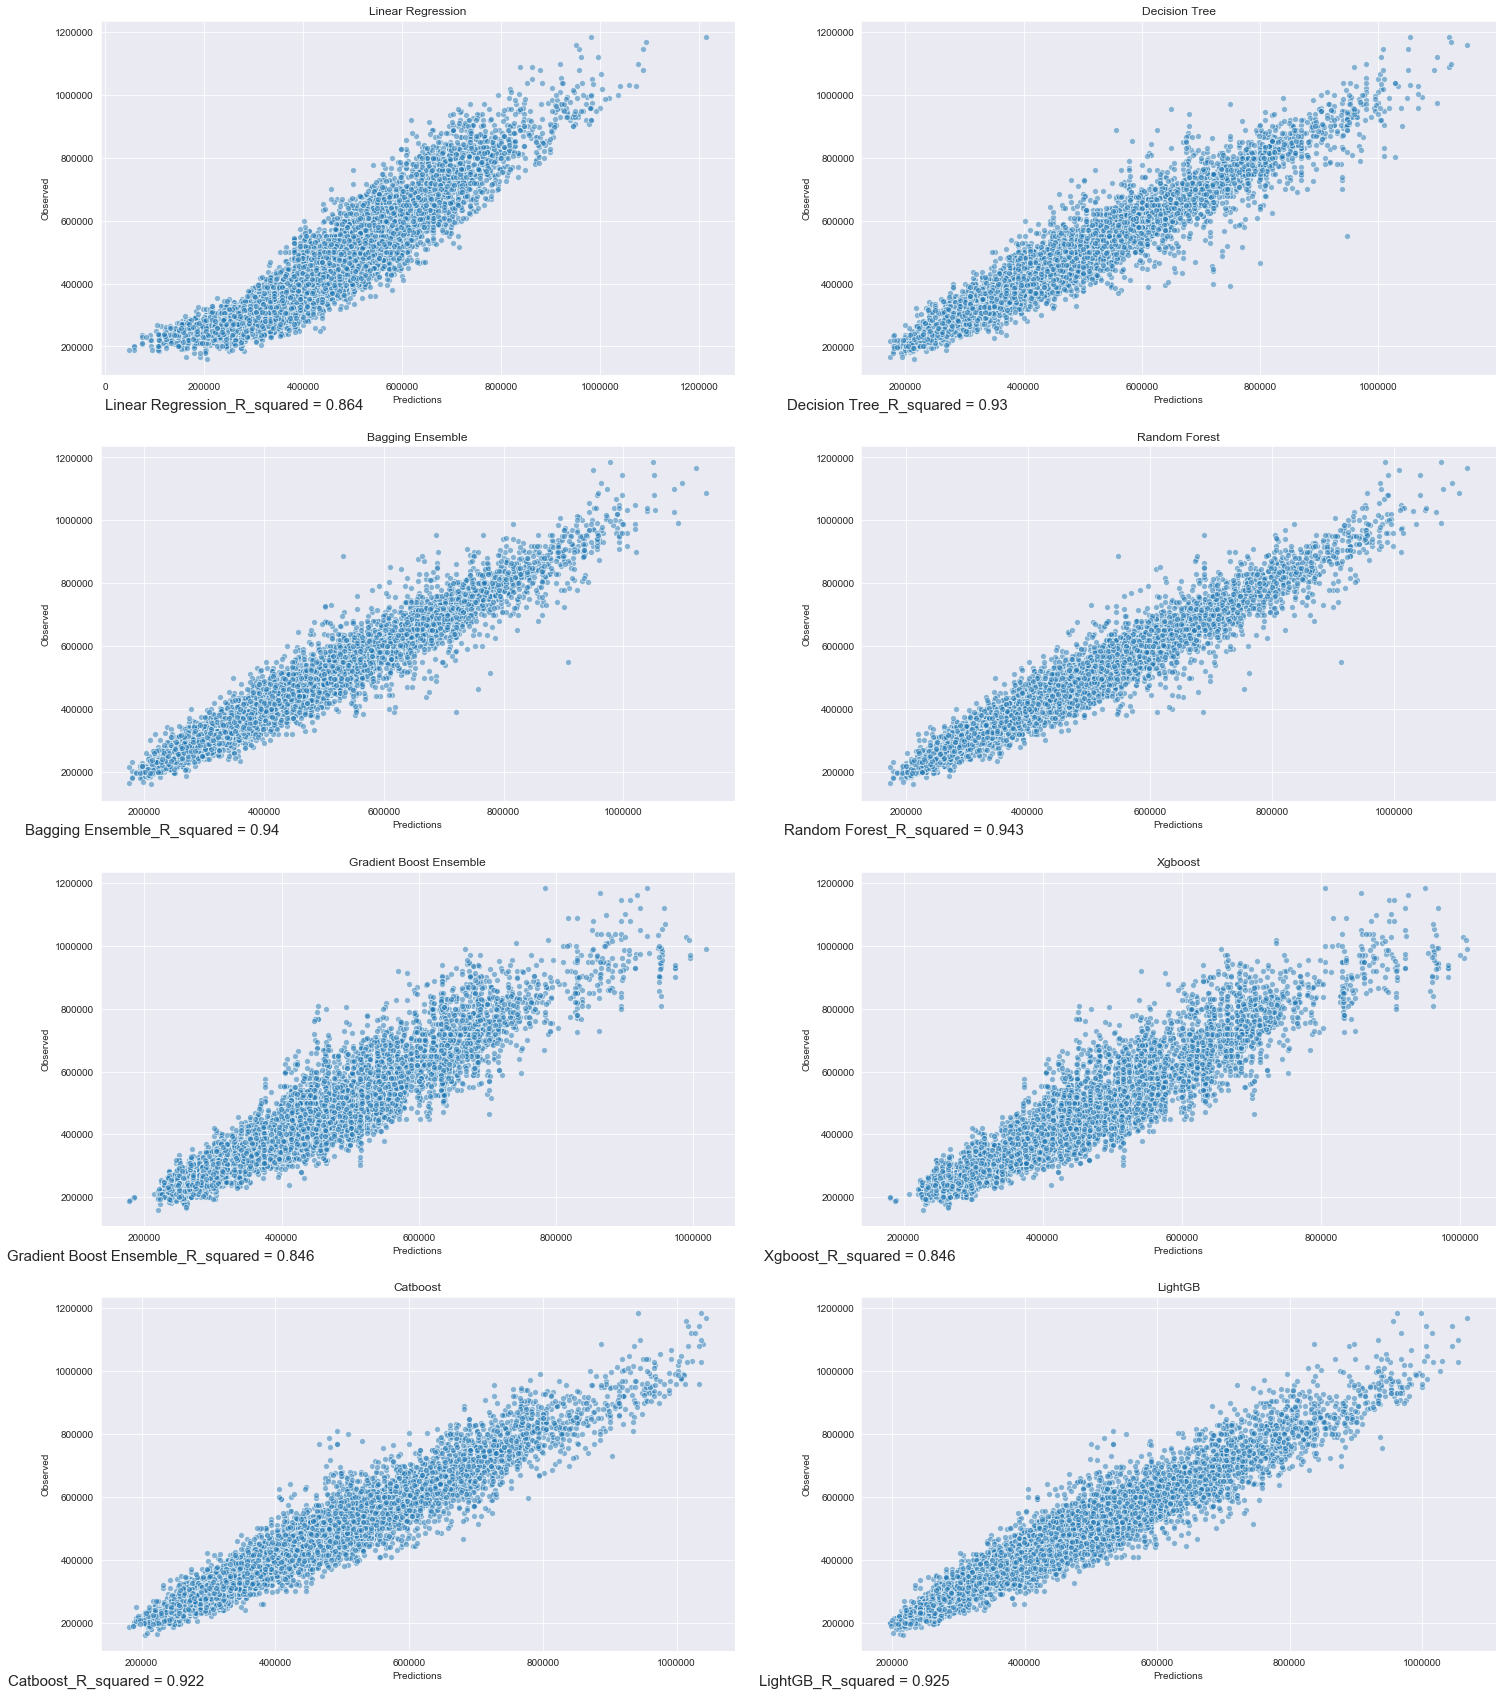

In [26]:
plt.figure(figsize= (25,30))

for pos in range(1,9):
    plt.subplot(4, 2, pos)
    plt.scatter(np.array(list(result.values()))[:,-1][pos-1], y_test, alpha= 0.5, edgecolors='white')
    plt.xlabel('Predictions')
    plt.ylabel('Observed')
    plt.title(list(result.keys())[pos-1])
    plt.text(0, 0, f'{list(result.keys())[pos-1]}_R_squared = {round(np.array(list(result.values()))[:,0][pos-1], 3)}',
             fontsize = 15)
    pos += 1
    

- Apart from the numbers, we can use some visuals to compare the performances of the models
- In each of the plots, the x axis is the predictions and y-axis
- The closer the swarm of points is to the diagonal, the better the predictions are

# Final Remarks
- Xgboost, Catboost and Lightgb are libraries which contain implimentations of the classic Gradient Boosting algorithm
- These libraries have tried to regularize the Gradient Boosting algorithm and improvise GBM for various aspects like computing speed, computing resources, leveraging GPUs etc
- We have seen Random forest (with 100 estimators), even though it gave a good performance, took a long time to process, where as all the new boosting algos took lesser time  for the same number of estimators and specifically LightGBM was relatively super fast 
- However, the new boosting algos have not performed the best
- Maybe they are not as good with Regression as they are with Classification
- One major advantage of the GBM variants are the processing capability. They can handle very large datasets in relatively less time, optimal resource usage and apparently better performance compared to the traditional algorithms. Allbeit, we cannot show case it here since we are limited with the datasize hardware resources

# Reference links
- [Xgboost](https://xgboost.readthedocs.io/en/latest/)
- [Catboost](https://catboost.ai/)
- [lightGBM](https://lightgbm.readthedocs.io/en/latest/)